In [1]:
!git clone https://github.com/dercodeKoenig/hft_dqn
!mv hft_dqn/*.py .
!rm -r hft_dqn

Cloning into 'hft_dqn'...
remote: Enumerating objects: 791, done.
remote: Counting objects: 100% (92/92), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 791 (delta 59), reused 75 (delta 49), pack-reused 699 (from 1)
Receiving objects: 100% (791/791), 378.92 MiB | 36.29 MiB/s, done.
Resolving deltas: 100% (452/452), done.


In [2]:
!pip install tensorflow==2.18.0 keras h5py keras==3.8.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 16.8 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstalling keras-3.5.0:
      Successfully uninstalled keras-3.5.0


In [3]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

from MultiTimeframeCandleManager import *
from datetime import datetime, timedelta
import time
from collections import deque
import numpy as np
import copy
import tensorflow as tf
from tqdm import tqdm
import random
from save_and_load import *
from Candle import Candle
import matplotlib.pyplot as plt
from tensorflow.keras.layers import (
        Input, Lambda, Concatenate, Dense, Embedding, Dropout, LSTM, 
        MultiHeadAttention, LayerNormalization, LeakyReLU, GlobalAveragePooling1D
    )


#candles = obj_load("/content/NQ_2")[-100000:]
candles = obj_load("/kaggle/input/us-futures-1-minute-candlesticks/NQ_1")#[40000:]
len(candles)

2025-04-14 22:47:40.413805: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744670860.623270      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744670860.681144      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


loading /kaggle/input/us-futures-1-minute-candlesticks/NQ_1


99990

In [4]:

def make_model():
    dropout_rate = 0.05  # adjust as needed

     ### Define helper to process a chart input (shape: (60,5))
    def process_chart(chart_input, name):
        # Separate OHLC (first 4 columns) and time (5th column)
        ohlc = Lambda(lambda x: tf.clip_by_value(x[:, :, :4], -1000.0, 1000.0), name=f'{name}_clip_ohlc')(chart_input)
        t = Lambda(lambda x: x[:, :, 4], name=f'{name}_extract_time')(chart_input)
        # Wrap tf.cast in a Lambda so that it's applied as a Keras operation
        t_int = Lambda(lambda x: tf.cast(x, tf.int32), name=f'{name}_cast_time')(t)
        # Embed the per-candle time (assumes integer inputs; adjust input_dim as appropriate)
        t_embed = Embedding(input_dim=60*24, output_dim=8, name=f'{name}_t_embed')(t_int)
        # Concatenate OHLC (4 dims) with the embedded time (8 dims) => result shape: (60, 12)
        return Concatenate(name=f'{name}_concat')([ohlc, t_embed])
    
    ### Inputs
    # Each chart now is (60,5): OHLC + per-candle time
    chart_m15 = Input(shape=(60,5), name='chart_m15')
    chart_m5  = Input(shape=(60,5), name='chart_m5')
    chart_m1  = Input(shape=(60,5), name='chart_m1')
    
    # PDAs input (same as before) and clip it (do not clip minutes here)
    pdas = Input(shape=(3*3 + 3*3 + 1 + 12*5 + 5*3,), name='pdas')
    pdas = Lambda(lambda x: tf.clip_by_value(x, -1000.0, 1000.0), name='clip_pdas')(pdas)
    
    # Global minutes input remains
    minutes = Input(shape=(1,), name='minutes')
    minutes_embed = Embedding(input_dim=60*24, output_dim=8, name='global_minutes_embed')(minutes)  # shape (batch, 1, 8)
    
    ### Process each chart
    m15_processed = process_chart(chart_m15, 'm15')
    m5_processed  = process_chart(chart_m5, 'm5')
    m1_processed  = process_chart(chart_m1, 'm1')

    m15_with_tf = Concatenate(axis=-1, name='m15_with_tf')([
        m15_processed,
        Lambda(lambda x: tf.tile(tf.reshape(tf.constant([1., 0., 0.], dtype=tf.float32), (1, 1, 3)), 
                                 [tf.shape(x)[0], tf.shape(x)[1], 1]),
               name='m15_timeframe')(m15_processed)
    ])
    
    m5_with_tf = Concatenate(axis=-1, name='m5_with_tf')([
        m5_processed,
        Lambda(lambda x: tf.tile(tf.reshape(tf.constant([0., 1., 0.], dtype=tf.float32), (1, 1, 3)), 
                                 [tf.shape(x)[0], tf.shape(x)[1], 1]),
               name='m5_timeframe')(m5_processed)
    ])
    
    m1_with_tf = Concatenate(axis=-1, name='m1_with_tf')([
        m1_processed,
        Lambda(lambda x: tf.tile(tf.reshape(tf.constant([0., 0., 1.], dtype=tf.float32), (1, 1, 3)), 
                                 [tf.shape(x)[0], tf.shape(x)[1], 1]),
               name='m1_timeframe')(m1_processed)
    ])
    
    # Concatenate the charts along the time axis: resulting in shape (batch, 180, feature_dim)
    combined_charts = Concatenate(axis=1, name='charts_concat')([m15_with_tf, m5_with_tf, m1_with_tf])
    # At this point, each time step has 12 features (4 from OHLC + 8 from time embed)
    
    ### Repeat pdas and global minutes so they are added to every candle
    # Repeat PDAs to get shape (batch, 180, pdas_dim)
    pdas_repeated = Lambda(
        lambda x: tf.repeat(tf.expand_dims(x, axis=1), repeats=180, axis=1),
        name='pdas_repeated')(pdas)

    # Concat the charts with the repeated PDAs and minutes
    combined_sequence = Concatenate(axis=-1, name='combined_sequence')(
        [combined_charts, pdas_repeated]
    )
    # Now, if combined_charts has 12 features, pdas has, say, 94 dims, and global minutes 8 dims,
    # each time step will have 12 + 94 = 106 features.
    
    ### Define a transformer encoder block (like in a Transformer encoder)
    def transformer_encoder(inputs, head_dim, num_heads, ff_dim, dropout_rate, name):
        # Multi-head self-attention
        attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=head_dim, name=f'{name}_mha')(inputs, inputs)
        attn_output = Dropout(dropout_rate, name=f'{name}_attn_dropout')(attn_output)
        #out1 = LayerNormalization(epsilon=1e-6, name=f'{name}_attn_ln')(inputs + attn_output)
        out1 = inputs + attn_output
        # Feed-forward network
        ffn_output = Dense(ff_dim, activation='relu', name=f'{name}_ffn_dense1')(out1)
        ffn_output = Dense(inputs.shape[-1], name=f'{name}_ffn_dense2')(ffn_output)
        ffn_output = Dropout(dropout_rate, name=f'{name}_ffn_dropout')(ffn_output)
        #out2 = LayerNormalization(epsilon=1e-6, name=f'{name}_ffn_ln')(out1 + ffn_output)
        out2 = out1 + ffn_output
        return out2
    
    ### Apply transformer layers
    x = combined_sequence
    # convert the concat ohlc+t+pda to vector
    x = Dense(1024)(x)
    x = LeakyReLU(0.05)(x)
    x = Dense(4096)(x)
    x = LeakyReLU(0.05)(x)
    x = Dense(4096)(x)
    x = LeakyReLU(0.05)(x)
    x = Dense(128)(x)
    x = LeakyReLU(0.05)(x)


    # Feature dim after your Dense layers
    feature_dim = 128
    
    # Define learnable CLS token
    cls_token = tf.Variable(
        initial_value=tf.random.normal(shape=(1, 1, feature_dim)),
        trainable=True,
        name="cls_token"
    )
    
    # Wrap it in a Lambda so it works with batch size
    def prepend_cls(x):
        batch_size = tf.shape(x)[0]
        cls_broadcasted = tf.tile(cls_token, [batch_size, 1, 1])  # shape: (batch, 1, feature_dim)
        return tf.concat([cls_broadcasted, x], axis=1)
    
    x = Lambda(prepend_cls, name="prepend_cls_token")(x)

    
    x = transformer_encoder(x, head_dim=256, num_heads=32, ff_dim=512, dropout_rate=dropout_rate, name='trans_enc1')
    x = transformer_encoder(x, head_dim=256, num_heads=32, ff_dim=512, dropout_rate=dropout_rate, name='trans_enc2')
    x = transformer_encoder(x, head_dim=256, num_heads=32, ff_dim=512, dropout_rate=dropout_rate, name='trans_enc3')
    x = transformer_encoder(x, head_dim=256, num_heads=32, ff_dim=512, dropout_rate=dropout_rate, name='trans_enc4')
    x = transformer_encoder(x, head_dim=256, num_heads=32, ff_dim=512, dropout_rate=dropout_rate, name='trans_enc5')
    x = transformer_encoder(x, head_dim=256, num_heads=32, ff_dim=512, dropout_rate=dropout_rate, name='trans_enc6')
    x = transformer_encoder(x, head_dim=256, num_heads=32, ff_dim=512, dropout_rate=dropout_rate, name='trans_enc7')
    x = Lambda(lambda t: t[:, 0, :], name="extract_cls")(x)

    
    ### Summarize the sequence with an LSTM layer
    #lstm_out = LSTM(1024, return_sequences=False, name='final_lstm')(x)
    #x = tf.keras.layers.Flatten(name="flat")(x)
    
    
    ### Final dense tower
    d = Dense(4096, name='dense1')(x)
    d = LeakyReLU(0.05)(d)
    d = Dropout(0.1)(d)  # slightly increased dropout rate (tweak as needed)
    
    d = Dense(4096, name='dense2')(d)
    d = LeakyReLU(0.05)(d)
    d = Dropout(0.1)(d)
    
    d = Dense(4096, name='dense3')(d)
    d = LeakyReLU(0.05)(d)
    d = Dropout(0.1)(d)
    
    d = Dense(4096, name='dense4')(d)
    d = LeakyReLU(0.05)(d)
    d = Dropout(0.1)(d)

    ### Add Tanh before the softmax to stabilize the output
    d = Dense(1024, activation='tanh', name='pre_softmax_tanh')(d)  #
    
    ### Final output layer (3-class softmax)
    output = Dense(3, activation="softmax", dtype="float32", name='output')(d)
    
    ### Create and compile model
    model = tf.keras.Model(
        inputs=[chart_m15, chart_m5, chart_m1, pdas, minutes],
        outputs=output
    )

    return model

In [5]:
model = make_model()

I0000 00:00:1744670877.326163      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [6]:
model.load_weights("/kaggle/input/nn-train-v7/model.weights.h5")

In [7]:

class Order:
    def __init__(self, limit, stop, tp, direction):
        self.entry = limit
        self.tp = tp
        self.sl = stop
        self.direction = direction

class Position:
    def __init__(self, entry, stop, tp, direction):
        self.entry = entry
        self.tp = tp
        self.sl = stop
        self.direction = direction

In [8]:
def step(index):

        global current_position, current_order, slm, m, outputs, all_candles, cmm, equity, equity_L
    
        ret = m.push_m1_candle(candles[index])
        midnight_open, midnight_opening_range_high,midnight_opening_range_low, pdas, current_close, current_time, charts = ret
        center = (midnight_opening_range_high + midnight_opening_range_low) / 2
        r = max(0.0001, (midnight_opening_range_high - midnight_opening_range_low) / 2)



        current_candle_m1 = charts[2][-1]
        #### check tp before filling order so that the same m1 candle will not trigger tp - it is not sure if the candle hit first limit and later tp or reve3rse
        if current_position.direction == 1:
            if current_candle_m1.h >= current_position.tp:
                pnl = (current_position.tp - current_position.entry) * current_position.direction
                equity += pnl
                current_position = Position(0,0,0,0)
        if current_position.direction == -1:
            if current_candle_m1.l <= current_position.tp:
                pnl = (current_position.tp - current_position.entry) * current_position.direction
                equity += pnl
                current_position = Position(0,0,0,0)

        #### check order
        if current_order != None:
            if  current_order.direction == 1:
                if current_candle_m1.l < current_order.entry:
                    current_position = Position(current_order.entry, current_order.sl, current_order.tp, current_order.direction)
                    #print("fill long order:",current_order.entry, current_order.sl, current_order.tp)
                    equity -= cmm
                    current_order = None
        if current_order != None:
            if  current_order.direction == -1:
                if current_candle_m1.h > current_order.entry:
                    current_position = Position(current_order.entry, current_order.sl, current_order.tp, current_order.direction)
                    #print("fill short order:",current_order.entry, current_order.sl, current_order.tp)
                    equity -= cmm
                    current_order = None

        #### check sl
        if current_position.direction == 1:
            if current_candle_m1.l <= current_position.sl:
                pnl = (current_position.sl - current_position.entry) * current_position.direction
                equity += pnl
                current_position = Position(0,0,0,0)
        if current_position.direction == -1:
            if current_candle_m1.h >= current_position.sl:
                pnl = (current_position.sl - current_position.entry) * current_position.direction
                equity += pnl
                current_position = Position(0,0,0,0)




        if(len(m.ndogs) == 5 and len(m.fps) == 3 and len(m.opening_range_gaps) == 3 and len(m.asia_highs_lows) == 3 and len(m.london_highs_lows) == 3 and len(m.ny_am_highs_lows) == 3 and len(m.ny_lunch_highs_lows) == 3 and len(m.ny_pm_highs_lows) == 3):


            open_profit = (current_close - current_position.entry) * current_position.direction

            scaled_entry_diff  =  0
            scaled_sl_diff  =  0
            if(current_position.direction != 0):
                scaled_entry_diff = (current_close - current_position.entry) / r
                scaled_sl_diff = (current_close - current_position.sl) / r

            state = ret_to_scaled_inputs(ret) + [np.array([current_position.direction, scaled_entry_diff, scaled_sl_diff])]
            m15_np, m5_np, m1_np, pda_np, current_minutes, pos_info = state

            equity_L.append(equity+open_profit)
            all_candles.append(charts[2][-1])


            if True:#current_minutes >= 9*60+29 and current_minutes < 16*60:
                output = inference_step(
                    tf.expand_dims(m15_np, 0),
                    tf.expand_dims(m5_np, 0),
                    tf.expand_dims(m1_np, 0),
                    tf.expand_dims(pda_np, 0),
                    tf.expand_dims(current_minutes, 0),
                    #tf.expand_dims(pos_info, 0)
                )

              
                last_action = np.argmax(output)
                #last_action = np.argmax([output[0][0], output[0][1]])
                outputs.append(output[0])
            else:
                last_action = 2


            avg_candle_range = np.mean([ i.h - i.l for i in list(charts[2])])

            if(last_action == 2):
                #equity += open_profit
                #current_position = Position(0,0,0,0)
                #print("close position:", open_profit)
                current_order = None

            if(last_action == 0 and current_position.direction == 1):
                equity += open_profit
                current_position = Position(0,0,0,0)

            if(last_action == 0):
                last_candle_low = charts[2][-2].l
                if ( last_candle_low < current_close ):
                    last_candle_low = None

                pdas = m.normal_pdas ## (low, high)

                ## ignore pdas with low below close
                pdas_filtered = []
                for pda in pdas:
                        if(pda[0] > current_close):
                            pdas_filtered.append(pda)
                ### sort
                sorted_by_high = sorted(pdas_filtered, key = lambda x:x[1])
                sorted_by_low = sorted(pdas_filtered, key = lambda x:x[0])

                if(len(pdas_filtered) > 2):

                    ### entry is lowest i can get or immediate rebalance
                    entry = sorted_by_low[0][0]
                    if(last_candle_low != None):
                        entry = min(entry, last_candle_low)


                    #sl = entry + avg_candle_range * slm
                    sl = sorted_by_low[2][1]
                    tp = entry  -  avg_candle_range * tpm

                    if current_position.direction == 0:
                        current_order = Order(entry, sl, tp, -1)
                        #print("set short order:",entry,sl,tp)
                    if current_position.direction == -1:
                        #current_position.sl = sl
                        current_position.tp = tp



            if(last_action == 1 and current_position.direction == -1):
                equity += open_profit
                current_position = Position(0,0,0,0)

            if(last_action == 1):
                last_candle_high = charts[2][-2].h
                if ( last_candle_high > current_close ):
                    last_candle_high = None
                pdas = m.normal_pdas ## (low, high)

                ## ignore pdas with low below close
                pdas_filtered = []
                for pda in pdas:
                        if(pda[1] < current_close):
                            pdas_filtered.append(pda)
                ### sort
                sorted_by_high = sorted(pdas_filtered, key = lambda x:x[1], reverse=True)
                sorted_by_low = sorted(pdas_filtered, key = lambda x:x[0], reverse=True)

                if(len(pdas_filtered) > 2):
                    ### entry is lowest i can get or immediate rebalance
                    entry = sorted_by_high[0][1]
                    if(last_candle_high != None):
                        entry = max(entry, last_candle_high)

                    #sl = entry - avg_candle_range * slm
                    sl = sorted_by_high[2][0]
                    tp = entry  +  avg_candle_range * tpm

                    if current_position.direction == 0:
                        current_order = Order(entry, sl, tp, 1)
                        #print("set long order:",entry,sl,tp)
                    if current_position.direction == 1:
                        #current_position.sl = sl
                        current_position.tp = tp
                        



In [9]:
m = MultiTimeframeCandleManager()

#slm = 2
#tpm = 6

slm = 2
tpm = 6


current_position = Position(0,0,0,0)
current_order = None

equity = 0
equity_L = [0]

outputs = []
all_candles = []

cmm = 0.5

@tf.function()
def inference_step(m15_np, m5_np, m1_np, pda_np, current_minutes):
    return model([
        m15_np,
        m5_np,
        m1_np,
        pda_np,
        current_minutes
    ])



#for index in tqdm(range(len(candles))):
for index in tqdm(range(len(candles))):
    step(index)
    if( index % 100 == 0 ):
        print("\n", equity_L[-1])

print(equity_L[-1])

  3%|▎         | 3012/99990 [00:00<00:03, 30113.35it/s]


 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 -11.25

 12.5

 13.0

 23.25

 52.625


  6%|▌         | 6051/99990 [00:12<03:41, 423.67it/s]


 39.125

 56.375

 56.375

 59.625

 140.875

 201.375

 232.375

 106.375

 40.875

 52.125


  7%|▋         | 7110/99990 [00:30<10:20, 149.73it/s]


 56.875


  7%|▋         | 7116/99990 [00:30<10:22, 149.17it/s]


 87.375

 111.625

 139.375

 127.375

 127.625

 149.375


  8%|▊         | 7801/99990 [00:41<14:46, 103.95it/s]


 420.625

 512.125

 322.625

 228.375

 293.875


  8%|▊         | 8214/99990 [00:48<17:35, 86.94it/s] 


 347.125

 310.125


  8%|▊         | 8481/99990 [00:53<19:11, 79.49it/s]


 379.875

 370.375


  9%|▊         | 8659/99990 [00:56<20:11, 75.39it/s]


 365.375


  9%|▉         | 8781/99990 [00:58<20:54, 72.69it/s]


 329.375


  9%|▉         | 8866/99990 [00:59<21:26, 70.82it/s]


 459.625


  9%|▉         | 9003/99990 [01:02<22:37, 67.03it/s]


 438.375


  9%|▉         | 9109/99990 [01:04<24:46, 61.13it/s]


 433.375


  9%|▉         | 9210/99990 [01:05<27:54, 54.22it/s]


 458.375


  9%|▉         | 9312/99990 [01:07<26:12, 57.68it/s]


 602.625


  9%|▉         | 9408/99990 [01:09<25:59, 58.07it/s]


 589.875


 10%|▉         | 9510/99990 [01:11<25:54, 58.22it/s]


 673.875


 10%|▉         | 9612/99990 [01:12<25:46, 58.45it/s]


 636.875


 10%|▉         | 9708/99990 [01:14<25:47, 58.33it/s]


 665.625


 10%|▉         | 9810/99990 [01:16<25:40, 58.53it/s]


 885.3499999999985


 10%|▉         | 9912/99990 [01:18<25:42, 58.38it/s]


 859.5999999999985


 10%|█         | 10008/99990 [01:19<25:40, 58.42it/s]


 876.0999999999985


 10%|█         | 10110/99990 [01:21<25:40, 58.35it/s]


 927.5999999999985


 10%|█         | 10212/99990 [01:23<25:36, 58.44it/s]


 931.0999999999985


 10%|█         | 10308/99990 [01:24<25:43, 58.10it/s]


 1008.3499999999985


 10%|█         | 10410/99990 [01:26<25:38, 58.22it/s]


 1008.0999999999985


 11%|█         | 10512/99990 [01:28<25:43, 57.97it/s]


 1142.0999999999985


 11%|█         | 10608/99990 [01:29<25:46, 57.80it/s]


 1403.8499999999985


 11%|█         | 10710/99990 [01:31<25:40, 57.97it/s]


 1595.5999999999985


 11%|█         | 10812/99990 [01:33<26:06, 56.95it/s]


 1841.8499999999985


 11%|█         | 10908/99990 [01:35<25:26, 58.36it/s]


 1737.3499999999985


 11%|█         | 11010/99990 [01:36<25:37, 57.86it/s]


 1691.8499999999985


 11%|█         | 11112/99990 [01:38<26:23, 56.12it/s]


 1683.0999999999985


 11%|█         | 11208/99990 [01:40<25:43, 57.53it/s]


 1715.8499999999985


 11%|█▏        | 11310/99990 [01:42<25:39, 57.62it/s]


 1721.8499999999985


 11%|█▏        | 11412/99990 [01:43<25:37, 57.60it/s]


 1715.3499999999985


 12%|█▏        | 11508/99990 [01:45<25:31, 57.78it/s]


 1731.5999999999985


 12%|█▏        | 11610/99990 [01:47<25:20, 58.12it/s]


 1697.3499999999985


 12%|█▏        | 11712/99990 [01:49<25:27, 57.81it/s]


 1697.3499999999985


 12%|█▏        | 11808/99990 [01:50<25:24, 57.83it/s]


 1697.3499999999985


 12%|█▏        | 11910/99990 [01:52<25:27, 57.68it/s]


 1707.8499999999985


 12%|█▏        | 12012/99990 [01:54<25:26, 57.63it/s]


 1921.8499999999985


 12%|█▏        | 12108/99990 [01:55<25:20, 57.81it/s]


 1781.8499999999985


 12%|█▏        | 12210/99990 [01:57<25:17, 57.86it/s]


 1777.8499999999985


 12%|█▏        | 12312/99990 [01:59<25:08, 58.14it/s]


 1779.5999999999985


 12%|█▏        | 12408/99990 [02:01<25:20, 57.59it/s]


 1799.5999999999985


 13%|█▎        | 12510/99990 [02:02<25:04, 58.15it/s]


 1825.0999999999985


 13%|█▎        | 12612/99990 [02:04<25:04, 58.09it/s]


 1833.0999999999985


 13%|█▎        | 12708/99990 [02:06<24:59, 58.20it/s]


 1844.8499999999985


 13%|█▎        | 12810/99990 [02:08<25:03, 57.99it/s]


 1879.3499999999985


 13%|█▎        | 12906/99990 [02:09<26:21, 55.06it/s]


 1891.5999999999985


 13%|█▎        | 13008/99990 [02:11<25:07, 57.71it/s]


 1967.5999999999985


 13%|█▎        | 13110/99990 [02:13<25:32, 56.71it/s]


 2023.3499999999985


 13%|█▎        | 13212/99990 [02:15<24:42, 58.54it/s]


 2058.0999999999985


 13%|█▎        | 13308/99990 [02:16<24:57, 57.88it/s]


 2131.8499999999985


 13%|█▎        | 13410/99990 [02:18<24:52, 58.00it/s]


 2193.8499999999985


 14%|█▎        | 13512/99990 [02:20<24:37, 58.54it/s]


 2282.5999999999985


 14%|█▎        | 13608/99990 [02:21<24:44, 58.18it/s]


 2322.274999999998


 14%|█▎        | 13710/99990 [02:23<25:09, 57.16it/s]


 2412.024999999998


 14%|█▍        | 13812/99990 [02:25<24:31, 58.58it/s]


 2410.774999999998


 14%|█▍        | 13908/99990 [02:27<24:35, 58.36it/s]


 2414.4249999999993


 14%|█▍        | 14010/99990 [02:28<24:35, 58.29it/s]


 2427.6749999999993


 14%|█▍        | 14112/99990 [02:30<24:33, 58.27it/s]


 2456.4249999999993


 14%|█▍        | 14208/99990 [02:32<24:35, 58.15it/s]


 2452.899999999998


 14%|█▍        | 14310/99990 [02:33<24:32, 58.20it/s]


 2458.9999999999964


 14%|█▍        | 14412/99990 [02:35<24:40, 57.82it/s]


 2459.2499999999964


 15%|█▍        | 14508/99990 [02:37<24:25, 58.35it/s]


 2487.849999999995


 15%|█▍        | 14610/99990 [02:39<24:16, 58.64it/s]


 2461.349999999995


 15%|█▍        | 14712/99990 [02:40<24:35, 57.81it/s]


 2729.4999999999964


 15%|█▍        | 14808/99990 [02:42<25:33, 55.56it/s]


 2667.2499999999964


 15%|█▍        | 14910/99990 [02:44<24:26, 58.00it/s]


 2651.7499999999964


 15%|█▌        | 15012/99990 [02:46<24:32, 57.69it/s]


 2776.9999999999964


 15%|█▌        | 15108/99990 [02:47<24:16, 58.29it/s]


 2770.2499999999964


 15%|█▌        | 15210/99990 [02:49<24:20, 58.04it/s]


 2718.4999999999964


 15%|█▌        | 15312/99990 [02:51<24:12, 58.28it/s]


 2689.7499999999964


 15%|█▌        | 15408/99990 [02:52<24:11, 58.28it/s]


 2700.7499999999964


 16%|█▌        | 15510/99990 [02:54<24:20, 57.86it/s]


 2722.699999999997


 16%|█▌        | 15612/99990 [02:56<24:08, 58.25it/s]


 2793.449999999997


 16%|█▌        | 15708/99990 [02:58<24:16, 57.85it/s]


 2765.699999999997


 16%|█▌        | 15810/99990 [02:59<24:24, 57.47it/s]


 2741.949999999997


 16%|█▌        | 15912/99990 [03:01<24:04, 58.19it/s]


 2872.149999999998


 16%|█▌        | 16008/99990 [03:03<25:30, 54.87it/s]


 2986.649999999998


 16%|█▌        | 16110/99990 [03:05<24:02, 58.16it/s]


 2847.899999999998


 16%|█▌        | 16212/99990 [03:06<24:09, 57.79it/s]


 2929.149999999998


 16%|█▋        | 16308/99990 [03:08<24:04, 57.92it/s]


 3019.149999999998


 16%|█▋        | 16410/99990 [03:10<24:04, 57.85it/s]


 3055.149999999998


 17%|█▋        | 16512/99990 [03:12<24:00, 57.97it/s]


 3090.649999999998


 17%|█▋        | 16608/99990 [03:13<25:24, 54.69it/s]


 3119.649999999998


 17%|█▋        | 16710/99990 [03:15<24:13, 57.30it/s]


 3084.399999999998


 17%|█▋        | 16812/99990 [03:17<23:57, 57.85it/s]


 3114.899999999998


 17%|█▋        | 16908/99990 [03:18<24:01, 57.62it/s]


 3082.649999999998


 17%|█▋        | 17010/99990 [03:20<23:55, 57.82it/s]


 3126.649999999998


 17%|█▋        | 17112/99990 [03:22<23:55, 57.73it/s]


 3144.399999999998


 17%|█▋        | 17208/99990 [03:24<23:53, 57.75it/s]


 3108.399999999998


 17%|█▋        | 17310/99990 [03:25<23:48, 57.87it/s]


 3095.399999999998


 17%|█▋        | 17412/99990 [03:27<23:47, 57.86it/s]


 3098.899999999998


 18%|█▊        | 17508/99990 [03:29<23:47, 57.78it/s]


 3159.399999999998


 18%|█▊        | 17610/99990 [03:31<23:36, 58.14it/s]


 3174.899999999998


 18%|█▊        | 17712/99990 [03:32<23:39, 57.95it/s]


 3200.899999999998


 18%|█▊        | 17808/99990 [03:34<23:41, 57.83it/s]


 3196.899999999998


 18%|█▊        | 17910/99990 [03:36<23:37, 57.88it/s]


 3256.149999999998


 18%|█▊        | 18012/99990 [03:38<23:37, 57.83it/s]


 3236.149999999998


 18%|█▊        | 18108/99990 [03:39<23:32, 57.98it/s]


 3284.899999999998


 18%|█▊        | 18210/99990 [03:41<23:39, 57.61it/s]


 3367.149999999998


 18%|█▊        | 18312/99990 [03:43<24:18, 55.99it/s]


 3358.6249999999964


 18%|█▊        | 18408/99990 [03:44<23:40, 57.42it/s]


 3607.1249999999964


 19%|█▊        | 18510/99990 [03:46<24:39, 55.07it/s]


 3478.6249999999964


 19%|█▊        | 18612/99990 [03:48<23:34, 57.55it/s]


 3513.8749999999964


 19%|█▊        | 18708/99990 [03:50<23:29, 57.66it/s]


 3555.3749999999964


 19%|█▉        | 18810/99990 [03:52<23:18, 58.04it/s]


 3447.6249999999964


 19%|█▉        | 18912/99990 [03:53<23:23, 57.78it/s]


 3540.3749999999964


 19%|█▉        | 19008/99990 [03:55<23:12, 58.15it/s]


 3590.574999999997


 19%|█▉        | 19110/99990 [03:57<23:01, 58.55it/s]


 3582.324999999997


 19%|█▉        | 19212/99990 [03:58<23:06, 58.28it/s]


 3628.074999999997


 19%|█▉        | 19308/99990 [04:00<22:57, 58.59it/s]


 3676.824999999997


 19%|█▉        | 19410/99990 [04:02<23:13, 57.82it/s]


 3804.824999999997


 20%|█▉        | 19512/99990 [04:04<23:19, 57.49it/s]


 3841.324999999997


 20%|█▉        | 19608/99990 [04:05<22:59, 58.25it/s]


 3897.824999999997


 20%|█▉        | 19710/99990 [04:07<23:03, 58.04it/s]


 3950.824999999997


 20%|█▉        | 19812/99990 [04:09<23:04, 57.91it/s]


 3952.824999999997


 20%|█▉        | 19908/99990 [04:10<23:05, 57.80it/s]


 4063.574999999997


 20%|██        | 20010/99990 [04:12<22:59, 57.97it/s]


 4084.074999999997


 20%|██        | 20112/99990 [04:14<22:58, 57.93it/s]


 4174.324999999997


 20%|██        | 20208/99990 [04:16<22:54, 58.03it/s]


 4268.924999999999


 20%|██        | 20310/99990 [04:17<24:11, 54.90it/s]


 4275.424999999999


 20%|██        | 20412/99990 [04:19<23:09, 57.25it/s]


 4273.674999999999


 21%|██        | 20508/99990 [04:21<22:57, 57.72it/s]


 4302.424999999999


 21%|██        | 20610/99990 [04:23<22:54, 57.76it/s]


 4302.174999999999


 21%|██        | 20712/99990 [04:25<22:51, 57.78it/s]


 4247.424999999999


 21%|██        | 20808/99990 [04:26<22:45, 58.00it/s]


 4282.924999999999


 21%|██        | 20910/99990 [04:28<22:51, 57.65it/s]


 4388.424999999999


 21%|██        | 21012/99990 [04:30<22:49, 57.69it/s]


 4375.674999999999


 21%|██        | 21108/99990 [04:31<22:53, 57.45it/s]


 4399.174999999999


 21%|██        | 21210/99990 [04:33<23:01, 57.02it/s]


 4576.424999999999


 21%|██▏       | 21312/99990 [04:35<22:29, 58.31it/s]


 4427.174999999999


 21%|██▏       | 21408/99990 [04:37<22:34, 58.00it/s]


 4567.674999999999


 22%|██▏       | 21510/99990 [04:38<22:32, 58.02it/s]


 4697.174999999999


 22%|██▏       | 21612/99990 [04:40<22:31, 57.97it/s]


 4706.924999999999


 22%|██▏       | 21708/99990 [04:42<22:41, 57.50it/s]


 4704.174999999999


 22%|██▏       | 21810/99990 [04:44<22:34, 57.71it/s]


 4698.424999999999


 22%|██▏       | 21912/99990 [04:45<22:23, 58.13it/s]


 4694.924999999999


 22%|██▏       | 22008/99990 [04:47<22:21, 58.11it/s]


 4718.674999999999


 22%|██▏       | 22110/99990 [04:49<22:12, 58.42it/s]


 4683.424999999999


 22%|██▏       | 22212/99990 [04:51<23:16, 55.70it/s]


 4662.424999999999


 22%|██▏       | 22308/99990 [04:52<22:28, 57.61it/s]


 4686.924999999999


 22%|██▏       | 22410/99990 [04:54<22:26, 57.63it/s]


 4806.75


 23%|██▎       | 22512/99990 [04:56<22:17, 57.91it/s]


 4799.25


 23%|██▎       | 22608/99990 [04:57<22:19, 57.76it/s]


 4813.5


 23%|██▎       | 22710/99990 [04:59<22:08, 58.16it/s]


 4772.5


 23%|██▎       | 22812/99990 [05:01<22:17, 57.71it/s]


 4810.75


 23%|██▎       | 22908/99990 [05:03<22:32, 57.00it/s]


 4777.75


 23%|██▎       | 23010/99990 [05:04<22:12, 57.76it/s]


 4761.75


 23%|██▎       | 23112/99990 [05:06<22:14, 57.59it/s]


 4783.25


 23%|██▎       | 23208/99990 [05:08<22:03, 58.00it/s]


 4806.5


 23%|██▎       | 23310/99990 [05:10<22:01, 58.02it/s]


 4875.25


 23%|██▎       | 23412/99990 [05:11<22:07, 57.70it/s]


 5012.0


 24%|██▎       | 23508/99990 [05:13<22:28, 56.74it/s]


 4934.5


 24%|██▎       | 23610/99990 [05:15<21:57, 57.97it/s]


 4957.75


 24%|██▎       | 23712/99990 [05:17<21:53, 58.06it/s]


 5079.0


 24%|██▍       | 23808/99990 [05:18<21:45, 58.35it/s]


 5161.0


 24%|██▍       | 23910/99990 [05:20<21:47, 58.20it/s]


 5201.25


 24%|██▍       | 24012/99990 [05:22<22:56, 55.21it/s]


 5150.75


 24%|██▍       | 24108/99990 [05:23<22:08, 57.11it/s]


 5154.25


 24%|██▍       | 24210/99990 [05:25<21:45, 58.06it/s]


 5336.5999999999985


 24%|██▍       | 24312/99990 [05:27<21:37, 58.31it/s]


 5342.8499999999985


 24%|██▍       | 24408/99990 [05:29<21:35, 58.33it/s]


 5361.0999999999985


 25%|██▍       | 24510/99990 [05:30<21:37, 58.17it/s]


 5363.0999999999985


 25%|██▍       | 24612/99990 [05:32<21:50, 57.52it/s]


 5341.0999999999985


 25%|██▍       | 24708/99990 [05:34<21:46, 57.62it/s]


 5332.0999999999985


 25%|██▍       | 24810/99990 [05:36<21:36, 58.01it/s]


 5361.5999999999985


 25%|██▍       | 24912/99990 [05:37<21:47, 57.44it/s]


 5376.5999999999985


 25%|██▌       | 25008/99990 [05:39<21:30, 58.11it/s]


 5367.3499999999985


 25%|██▌       | 25110/99990 [05:41<21:35, 57.80it/s]


 5533.5999999999985


 25%|██▌       | 25212/99990 [05:43<21:24, 58.20it/s]


 5674.0999999999985


 25%|██▌       | 25308/99990 [05:44<21:37, 57.54it/s]


 5594.0999999999985


 25%|██▌       | 25410/99990 [05:46<21:25, 58.03it/s]


 5602.0999999999985


 26%|██▌       | 25512/99990 [05:48<21:08, 58.73it/s]


 5607.5999999999985


 26%|██▌       | 25608/99990 [05:49<21:29, 57.66it/s]


 5680.0999999999985


 26%|██▌       | 25710/99990 [05:51<21:10, 58.46it/s]


 5678.3499999999985


 26%|██▌       | 25812/99990 [05:53<21:55, 56.38it/s]


 5678.3499999999985


 26%|██▌       | 25908/99990 [05:55<21:55, 56.33it/s]


 5678.3499999999985


 26%|██▌       | 26010/99990 [05:56<21:12, 58.15it/s]


 5672.8499999999985


 26%|██▌       | 26112/99990 [05:58<21:26, 57.44it/s]


 5715.8499999999985


 26%|██▌       | 26208/99990 [06:00<21:29, 57.21it/s]


 5676.0999999999985


 26%|██▋       | 26310/99990 [06:02<21:18, 57.62it/s]


 5647.8499999999985


 26%|██▋       | 26412/99990 [06:03<21:29, 57.05it/s]


 5694.0999999999985


 27%|██▋       | 26508/99990 [06:05<21:17, 57.54it/s]


 5645.3499999999985


 27%|██▋       | 26610/99990 [06:07<21:22, 57.23it/s]


 5689.3499999999985


 27%|██▋       | 26712/99990 [06:09<21:04, 57.96it/s]


 5698.9749999999985


 27%|██▋       | 26808/99990 [06:10<21:00, 58.05it/s]


 5768.25


 27%|██▋       | 26910/99990 [06:12<21:01, 57.93it/s]


 5708.75


 27%|██▋       | 27012/99990 [06:14<21:08, 57.52it/s]


 5660.75


 27%|██▋       | 27108/99990 [06:15<21:04, 57.65it/s]


 5656.75


 27%|██▋       | 27210/99990 [06:17<21:06, 57.48it/s]


 5729.75


 27%|██▋       | 27312/99990 [06:19<20:55, 57.88it/s]


 5766.25


 27%|██▋       | 27408/99990 [06:21<20:56, 57.76it/s]


 5820.0


 28%|██▊       | 27510/99990 [06:22<21:06, 57.23it/s]


 5821.75


 28%|██▊       | 27612/99990 [06:24<20:55, 57.66it/s]


 5794.25


 28%|██▊       | 27708/99990 [06:26<22:05, 54.53it/s]


 5883.200000000001


 28%|██▊       | 27810/99990 [06:28<20:44, 57.98it/s]


 5802.200000000001


 28%|██▊       | 27912/99990 [06:29<20:39, 58.15it/s]


 5804.200000000001


 28%|██▊       | 28008/99990 [06:31<20:38, 58.13it/s]


 5765.700000000001


 28%|██▊       | 28110/99990 [06:33<21:18, 56.24it/s]


 5779.950000000001


 28%|██▊       | 28212/99990 [06:35<20:38, 57.96it/s]


 5783.450000000001


 28%|██▊       | 28308/99990 [06:36<20:34, 58.07it/s]


 5781.450000000001


 28%|██▊       | 28410/99990 [06:38<20:33, 58.02it/s]


 5761.200000000001


 29%|██▊       | 28512/99990 [06:40<20:36, 57.80it/s]


 5774.450000000001


 29%|██▊       | 28608/99990 [06:41<20:31, 57.96it/s]


 5799.450000000001


 29%|██▊       | 28710/99990 [06:43<20:34, 57.75it/s]


 5782.950000000001


 29%|██▉       | 28812/99990 [06:45<20:43, 57.23it/s]


 5768.950000000001


 29%|██▉       | 28908/99990 [06:47<20:29, 57.83it/s]


 5768.950000000001


 29%|██▉       | 29010/99990 [06:48<20:31, 57.64it/s]


 5805.475000000002


 29%|██▉       | 29112/99990 [06:50<20:21, 58.02it/s]


 5828.725000000002


 29%|██▉       | 29208/99990 [06:52<20:33, 57.38it/s]


 5843.475000000002


 29%|██▉       | 29310/99990 [06:54<20:26, 57.62it/s]


 5858.725000000002


 29%|██▉       | 29412/99990 [06:55<20:25, 57.57it/s]


 5920.225000000002


 30%|██▉       | 29508/99990 [06:57<20:18, 57.85it/s]


 5937.475000000002


 30%|██▉       | 29610/99990 [06:59<20:48, 56.36it/s]


 5948.225000000002


 30%|██▉       | 29712/99990 [07:01<20:15, 57.81it/s]


 5940.475000000002


 30%|██▉       | 29808/99990 [07:02<20:17, 57.67it/s]


 5917.475000000002


 30%|██▉       | 29910/99990 [07:04<20:10, 57.90it/s]


 5936.975000000002


 30%|███       | 30012/99990 [07:06<20:15, 57.56it/s]


 6005.975000000002


 30%|███       | 30108/99990 [07:07<20:00, 58.21it/s]


 5995.975000000002


 30%|███       | 30210/99990 [07:09<19:58, 58.21it/s]


 5989.975000000002


 30%|███       | 30312/99990 [07:11<20:02, 57.92it/s]


 5986.725000000002


 30%|███       | 30408/99990 [07:13<20:12, 57.40it/s]


 5909.975000000002


 31%|███       | 30510/99990 [07:14<20:00, 57.87it/s]


 5881.725000000002


 31%|███       | 30612/99990 [07:16<19:49, 58.30it/s]


 5934.475000000002


 31%|███       | 30708/99990 [07:18<19:54, 58.01it/s]


 5984.725000000002


 31%|███       | 30810/99990 [07:20<19:49, 58.16it/s]


 5978.1500000000015


 31%|███       | 30912/99990 [07:21<20:01, 57.52it/s]


 5954.1500000000015


 31%|███       | 31008/99990 [07:23<20:10, 56.99it/s]


 5979.9000000000015


 31%|███       | 31110/99990 [07:25<19:51, 57.80it/s]


 6004.4000000000015


 31%|███       | 31212/99990 [07:27<19:44, 58.06it/s]


 5989.4000000000015


 31%|███▏      | 31308/99990 [07:28<19:56, 57.38it/s]


 5979.9000000000015


 31%|███▏      | 31410/99990 [07:30<20:44, 55.12it/s]


 5991.6500000000015


 32%|███▏      | 31512/99990 [07:32<19:42, 57.89it/s]


 6010.6500000000015


 32%|███▏      | 31608/99990 [07:33<19:45, 57.67it/s]


 6010.9000000000015


 32%|███▏      | 31710/99990 [07:35<19:41, 57.80it/s]


 6009.1500000000015


 32%|███▏      | 31812/99990 [07:37<19:37, 57.92it/s]


 5989.4000000000015


 32%|███▏      | 31908/99990 [07:39<19:31, 58.09it/s]


 6125.9000000000015


 32%|███▏      | 32010/99990 [07:40<19:27, 58.25it/s]


 6066.6500000000015


 32%|███▏      | 32112/99990 [07:42<19:30, 58.01it/s]


 6127.7750000000015


 32%|███▏      | 32208/99990 [07:44<19:30, 57.92it/s]


 6258.7750000000015


 32%|███▏      | 32310/99990 [07:46<19:33, 57.67it/s]


 6252.2750000000015


 32%|███▏      | 32412/99990 [07:47<19:20, 58.22it/s]


 6297.7750000000015


 33%|███▎      | 32508/99990 [07:49<19:13, 58.48it/s]


 6416.2750000000015


 33%|███▎      | 32610/99990 [07:51<19:16, 58.25it/s]


 6535.7750000000015


 33%|███▎      | 32712/99990 [07:53<19:28, 57.58it/s]


 6698.0250000000015


 33%|███▎      | 32808/99990 [07:54<19:29, 57.45it/s]


 6862.125


 33%|███▎      | 32910/99990 [07:56<19:14, 58.11it/s]


 6996.875


 33%|███▎      | 33012/99990 [07:58<19:14, 58.01it/s]


 7064.1500000000015


 33%|███▎      | 33108/99990 [07:59<19:10, 58.13it/s]


 7212.1500000000015


 33%|███▎      | 33210/99990 [08:01<19:06, 58.27it/s]


 7198.9000000000015


 33%|███▎      | 33306/99990 [08:03<21:08, 52.56it/s]


 7264.6500000000015


 33%|███▎      | 33408/99990 [08:05<18:57, 58.52it/s]


 7401.9000000000015


 34%|███▎      | 33510/99990 [08:06<19:06, 58.00it/s]


 7441.4000000000015


 34%|███▎      | 33612/99990 [08:08<19:05, 57.94it/s]


 7365.950000000001


 34%|███▎      | 33708/99990 [08:10<18:59, 58.17it/s]


 7358.200000000001


 34%|███▍      | 33810/99990 [08:12<19:02, 57.90it/s]


 7367.450000000001


 34%|███▍      | 33912/99990 [08:13<19:10, 57.44it/s]


 7409.950000000001


 34%|███▍      | 34008/99990 [08:15<18:57, 58.03it/s]


 7489.200000000001


 34%|███▍      | 34110/99990 [08:17<19:03, 57.61it/s]


 7502.700000000001


 34%|███▍      | 34212/99990 [08:19<18:53, 58.02it/s]


 7622.200000000001


 34%|███▍      | 34308/99990 [08:20<18:57, 57.75it/s]


 7709.450000000001


 34%|███▍      | 34410/99990 [08:22<18:42, 58.40it/s]


 7988.450000000001


 35%|███▍      | 34512/99990 [08:24<18:41, 58.39it/s]


 7887.200000000001


 35%|███▍      | 34608/99990 [08:25<18:47, 58.00it/s]


 7864.200000000001


 35%|███▍      | 34710/99990 [08:27<18:41, 58.22it/s]


 7960.700000000001


 35%|███▍      | 34812/99990 [08:29<18:38, 58.26it/s]


 7966.200000000001


 35%|███▍      | 34908/99990 [08:31<18:32, 58.49it/s]


 7967.450000000001


 35%|███▌      | 35010/99990 [08:32<18:27, 58.67it/s]


 7960.950000000001


 35%|███▌      | 35112/99990 [08:34<19:52, 54.43it/s]


 8000.700000000001


 35%|███▌      | 35208/99990 [08:36<18:41, 57.74it/s]


 7982.700000000001


 35%|███▌      | 35310/99990 [08:38<18:39, 57.77it/s]


 7964.700000000001


 35%|███▌      | 35412/99990 [08:39<18:39, 57.70it/s]


 7970.950000000001


 36%|███▌      | 35508/99990 [08:41<18:34, 57.88it/s]


 7952.950000000001


 36%|███▌      | 35610/99990 [08:43<18:56, 56.64it/s]


 7949.700000000001


 36%|███▌      | 35712/99990 [08:45<18:18, 58.53it/s]


 8032.450000000001


 36%|███▌      | 35808/99990 [08:46<18:19, 58.37it/s]


 8107.200000000001


 36%|███▌      | 35910/99990 [08:48<18:29, 57.78it/s]


 8102.700000000001


 36%|███▌      | 36007/99990 [08:50<18:04, 59.02it/s]


 8140.2750000000015


 36%|███▌      | 36109/99990 [08:51<18:18, 58.17it/s]


 7901.7750000000015


 36%|███▌      | 36211/99990 [08:53<18:30, 57.44it/s]


 7826.0250000000015


 36%|███▋      | 36307/99990 [08:55<18:09, 58.43it/s]


 7751.0250000000015


 36%|███▋      | 36409/99990 [08:56<18:03, 58.71it/s]


 7743.2750000000015


 37%|███▋      | 36511/99990 [08:58<18:05, 58.48it/s]


 7742.7750000000015


 37%|███▋      | 36607/99990 [09:00<18:09, 58.19it/s]


 7765.0250000000015


 37%|███▋      | 36709/99990 [09:02<18:10, 58.05it/s]


 7716.7750000000015


 37%|███▋      | 36811/99990 [09:03<18:12, 57.84it/s]


 7774.0250000000015


 37%|███▋      | 36907/99990 [09:05<17:57, 58.57it/s]


 7760.5250000000015


 37%|███▋      | 37009/99990 [09:07<18:41, 56.17it/s]


 7783.2750000000015


 37%|███▋      | 37111/99990 [09:09<18:04, 57.96it/s]


 7816.2750000000015


 37%|███▋      | 37207/99990 [09:10<17:58, 58.23it/s]


 7857.1500000000015


 37%|███▋      | 37309/99990 [09:12<17:59, 58.06it/s]


 7878.9000000000015


 37%|███▋      | 37411/99990 [09:14<17:50, 58.44it/s]


 7779.9000000000015


 38%|███▊      | 37507/99990 [09:15<17:54, 58.15it/s]


 7722.675000000003


 38%|███▊      | 37609/99990 [09:17<17:49, 58.34it/s]


 7718.425000000003


 38%|███▊      | 37711/99990 [09:19<17:42, 58.64it/s]


 7677.675000000003


 38%|███▊      | 37807/99990 [09:21<17:33, 59.05it/s]


 7698.675000000003


 38%|███▊      | 37909/99990 [09:22<17:39, 58.57it/s]


 7713.425000000003


 38%|███▊      | 38011/99990 [09:24<17:41, 58.41it/s]


 7731.925000000003


 38%|███▊      | 38107/99990 [09:26<17:34, 58.70it/s]


 7701.675000000003


 38%|███▊      | 38209/99990 [09:27<17:47, 57.86it/s]


 7724.175000000003


 38%|███▊      | 38311/99990 [09:29<17:33, 58.52it/s]


 7744.925000000003


 38%|███▊      | 38407/99990 [09:31<17:33, 58.44it/s]


 7734.425000000003


 39%|███▊      | 38509/99990 [09:33<17:45, 57.73it/s]


 7803.175000000003


 39%|███▊      | 38611/99990 [09:34<17:53, 57.18it/s]


 7865.175000000003


 39%|███▊      | 38707/99990 [09:36<17:31, 58.29it/s]


 7813.425000000003


 39%|███▉      | 38809/99990 [09:38<18:16, 55.80it/s]


 7654.675000000003


 39%|███▉      | 38911/99990 [09:40<17:43, 57.45it/s]


 7552.175000000003


 39%|███▉      | 39007/99990 [09:41<17:31, 57.97it/s]


 7552.175000000003


 39%|███▉      | 39109/99990 [09:43<17:44, 57.19it/s]


 7552.175000000003


 39%|███▉      | 39211/99990 [09:45<17:23, 58.26it/s]


 7552.175000000003


 39%|███▉      | 39307/99990 [09:46<17:20, 58.29it/s]


 7511.925000000003


 39%|███▉      | 39409/99990 [09:48<17:24, 57.98it/s]


 7417.675000000003


 40%|███▉      | 39511/99990 [09:50<17:19, 58.19it/s]


 7448.925000000003


 40%|███▉      | 39607/99990 [09:52<17:28, 57.61it/s]


 7396.175000000003


 40%|███▉      | 39709/99990 [09:53<17:32, 57.28it/s]


 7394.175000000003


 40%|███▉      | 39811/99990 [09:55<17:18, 57.97it/s]


 7354.925000000003


 40%|███▉      | 39907/99990 [09:57<17:12, 58.21it/s]


 7278.675000000003


 40%|████      | 40009/99990 [09:59<17:06, 58.46it/s]


 7094.675000000003


 40%|████      | 40111/99990 [10:00<17:13, 57.96it/s]


 7047.175000000003


 40%|████      | 40207/99990 [10:02<17:10, 58.00it/s]


 7057.175000000003


 40%|████      | 40309/99990 [10:04<17:09, 57.95it/s]


 7007.175000000003


 40%|████      | 40411/99990 [10:05<17:08, 57.92it/s]


 7044.175000000003


 41%|████      | 40507/99990 [10:07<16:57, 58.43it/s]


 7116.675000000003


 41%|████      | 40609/99990 [10:09<17:01, 58.12it/s]


 7066.175000000003


 41%|████      | 40711/99990 [10:11<17:26, 56.63it/s]


 7014.175000000003


 41%|████      | 40807/99990 [10:12<17:10, 57.45it/s]


 7073.925000000003


 41%|████      | 40909/99990 [10:14<17:01, 57.81it/s]


 7014.175000000003


 41%|████      | 41011/99990 [10:16<16:51, 58.31it/s]


 6946.675000000003


 41%|████      | 41107/99990 [10:18<16:52, 58.17it/s]


 6897.925000000003


 41%|████      | 41209/99990 [10:19<16:54, 57.95it/s]


 6815.425000000003


 41%|████▏     | 41311/99990 [10:21<16:47, 58.23it/s]


 6814.675000000003


 41%|████▏     | 41407/99990 [10:23<16:49, 58.04it/s]


 6824.925000000003


 42%|████▏     | 41509/99990 [10:25<16:54, 57.67it/s]


 6837.375000000004


 42%|████▏     | 41611/99990 [10:26<16:42, 58.26it/s]


 6839.375000000004


 42%|████▏     | 41707/99990 [10:28<16:41, 58.20it/s]


 6857.375000000004


 42%|████▏     | 41810/99990 [10:30<16:38, 58.25it/s]


 6814.625000000004


 42%|████▏     | 41912/99990 [10:31<16:36, 58.25it/s]


 6792.125000000004


 42%|████▏     | 42008/99990 [10:33<16:47, 57.57it/s]


 6810.625000000004


 42%|████▏     | 42110/99990 [10:35<16:52, 57.19it/s]


 6837.125000000004


 42%|████▏     | 42212/99990 [10:37<16:30, 58.33it/s]


 6840.625000000004


 42%|████▏     | 42308/99990 [10:38<16:36, 57.89it/s]


 6915.875000000004


 42%|████▏     | 42410/99990 [10:40<16:28, 58.24it/s]


 6932.625000000004


 43%|████▎     | 42512/99990 [10:42<17:07, 55.95it/s]


 6941.375000000004


 43%|████▎     | 42608/99990 [10:43<16:31, 57.89it/s]


 6873.625000000004


 43%|████▎     | 42710/99990 [10:45<16:18, 58.53it/s]


 6861.125000000004


 43%|████▎     | 42812/99990 [10:47<16:18, 58.46it/s]


 6844.375000000004


 43%|████▎     | 42908/99990 [10:49<16:14, 58.55it/s]


 6817.875000000004


 43%|████▎     | 43010/99990 [10:50<16:10, 58.68it/s]


 6817.875000000004


 43%|████▎     | 43112/99990 [10:52<16:24, 57.78it/s]


 6833.625000000004


 43%|████▎     | 43208/99990 [10:54<16:16, 58.14it/s]


 6840.375000000004


 43%|████▎     | 43310/99990 [10:56<16:02, 58.89it/s]


 6850.125000000004


 43%|████▎     | 43412/99990 [10:57<16:20, 57.69it/s]


 6887.625000000004


 44%|████▎     | 43508/99990 [10:59<16:03, 58.60it/s]


 6888.125000000004


 44%|████▎     | 43610/99990 [11:01<16:05, 58.39it/s]


 6885.375000000004


 44%|████▎     | 43712/99990 [11:02<15:56, 58.82it/s]


 6857.125000000004


 44%|████▍     | 43808/99990 [11:04<16:13, 57.72it/s]


 6877.375000000004


 44%|████▍     | 43910/99990 [11:06<16:08, 57.91it/s]


 6921.875000000004


 44%|████▍     | 44012/99990 [11:08<15:57, 58.44it/s]


 6808.125000000004


 44%|████▍     | 44108/99990 [11:09<16:11, 57.55it/s]


 6805.875000000004


 44%|████▍     | 44210/99990 [11:11<16:13, 57.29it/s]


 6830.775000000005


 44%|████▍     | 44312/99990 [11:13<16:35, 55.94it/s]


 6906.025000000005


 44%|████▍     | 44408/99990 [11:15<16:49, 55.05it/s]


 6903.525000000005


 45%|████▍     | 44510/99990 [11:16<16:01, 57.68it/s]


 6887.275000000005


 45%|████▍     | 44612/99990 [11:18<16:06, 57.30it/s]


 6892.025000000005


 45%|████▍     | 44708/99990 [11:20<16:02, 57.42it/s]


 6897.275000000005


 45%|████▍     | 44810/99990 [11:22<15:58, 57.59it/s]


 6930.275000000005


 45%|████▍     | 44912/99990 [11:23<15:50, 57.94it/s]


 6942.775000000005


 45%|████▌     | 45008/99990 [11:25<15:45, 58.18it/s]


 6938.525000000005


 45%|████▌     | 45110/99990 [11:27<15:40, 58.37it/s]


 6922.275000000005


 45%|████▌     | 45212/99990 [11:28<15:39, 58.28it/s]


 6959.175000000007


 45%|████▌     | 45308/99990 [11:30<15:35, 58.45it/s]


 7014.850000000006


 45%|████▌     | 45410/99990 [11:32<15:42, 57.91it/s]


 6976.100000000006


 46%|████▌     | 45512/99990 [11:34<15:38, 58.06it/s]


 6887.350000000006


 46%|████▌     | 45608/99990 [11:35<15:31, 58.38it/s]


 7034.100000000006


 46%|████▌     | 45710/99990 [11:37<15:25, 58.66it/s]


 7000.600000000006


 46%|████▌     | 45812/99990 [11:39<15:31, 58.13it/s]


 6952.350000000006


 46%|████▌     | 45908/99990 [11:40<15:35, 57.78it/s]


 6960.850000000006


 46%|████▌     | 46010/99990 [11:42<15:48, 56.92it/s]


 6936.350000000006


 46%|████▌     | 46112/99990 [11:44<15:41, 57.24it/s]


 6929.100000000006


 46%|████▌     | 46208/99990 [11:46<16:23, 54.70it/s]


 6907.850000000006


 46%|████▋     | 46310/99990 [11:47<15:28, 57.82it/s]


 6875.100000000006


 46%|████▋     | 46412/99990 [11:49<15:23, 58.03it/s]


 6854.850000000006


 47%|████▋     | 46508/99990 [11:51<15:28, 57.61it/s]


 6856.850000000006


 47%|████▋     | 46610/99990 [11:53<15:28, 57.49it/s]


 6918.850000000006


 47%|████▋     | 46712/99990 [11:54<15:15, 58.21it/s]


 6977.100000000006


 47%|████▋     | 46808/99990 [11:56<15:11, 58.33it/s]


 6981.850000000006


 47%|████▋     | 46910/99990 [11:58<15:11, 58.25it/s]


 6986.350000000006


 47%|████▋     | 47012/99990 [12:00<15:10, 58.19it/s]


 6948.350000000006


 47%|████▋     | 47108/99990 [12:01<14:58, 58.83it/s]


 6907.350000000006


 47%|████▋     | 47210/99990 [12:03<15:21, 57.27it/s]


 6922.850000000006


 47%|████▋     | 47312/99990 [12:05<15:01, 58.45it/s]


 6863.850000000006


 47%|████▋     | 47408/99990 [12:06<15:18, 57.22it/s]


 6889.350000000006


 48%|████▊     | 47510/99990 [12:08<14:55, 58.57it/s]


 6868.600000000006


 48%|████▊     | 47612/99990 [12:10<14:57, 58.35it/s]


 6852.350000000006


 48%|████▊     | 47708/99990 [12:11<14:57, 58.26it/s]


 6844.850000000006


 48%|████▊     | 47810/99990 [12:13<14:59, 58.00it/s]


 6839.600000000006


 48%|████▊     | 47912/99990 [12:15<14:46, 58.78it/s]


 6805.350000000006


 48%|████▊     | 48008/99990 [12:17<14:47, 58.56it/s]


 6873.100000000006


 48%|████▊     | 48111/99990 [12:18<15:12, 56.83it/s]


 6960.725000000006


 48%|████▊     | 48207/99990 [12:20<14:40, 58.81it/s]


 7052.050000000007


 48%|████▊     | 48309/99990 [12:22<14:34, 59.06it/s]


 7052.050000000007


 48%|████▊     | 48411/99990 [12:24<14:45, 58.28it/s]


 7052.050000000007


 49%|████▊     | 48507/99990 [12:25<14:47, 58.03it/s]


 7040.050000000007


 49%|████▊     | 48609/99990 [12:27<14:41, 58.27it/s]


 7024.050000000007


 49%|████▊     | 48711/99990 [12:29<14:36, 58.54it/s]


 7053.300000000007


 49%|████▉     | 48807/99990 [12:30<14:36, 58.38it/s]


 7048.800000000007


 49%|████▉     | 48909/99990 [12:32<14:38, 58.16it/s]


 7057.550000000007


 49%|████▉     | 49011/99990 [12:34<14:42, 57.79it/s]


 7055.800000000007


 49%|████▉     | 49107/99990 [12:36<14:41, 57.70it/s]


 7089.400000000005


 49%|████▉     | 49209/99990 [12:37<14:46, 57.31it/s]


 7074.900000000005


 49%|████▉     | 49311/99990 [12:39<14:43, 57.34it/s]


 7050.225000000006


 49%|████▉     | 49407/99990 [12:41<14:29, 58.18it/s]


 7250.725000000006


 50%|████▉     | 49509/99990 [12:43<14:30, 58.00it/s]


 7239.650000000005


 50%|████▉     | 49611/99990 [12:44<14:30, 57.89it/s]


 7206.400000000005


 50%|████▉     | 49707/99990 [12:46<14:26, 58.02it/s]


 7208.900000000005


 50%|████▉     | 49809/99990 [12:48<14:22, 58.17it/s]


 7276.900000000005


 50%|████▉     | 49911/99990 [12:50<14:59, 55.65it/s]


 7309.200000000004


 50%|█████     | 50007/99990 [12:51<14:29, 57.45it/s]


 7307.450000000004


 50%|█████     | 50109/99990 [12:53<14:37, 56.85it/s]


 7262.450000000004


 50%|█████     | 50211/99990 [12:55<14:24, 57.60it/s]


 7255.450000000004


 50%|█████     | 50307/99990 [12:56<14:18, 57.84it/s]


 7286.450000000004


 50%|█████     | 50409/99990 [12:58<14:15, 57.97it/s]


 7354.950000000004


 51%|█████     | 50511/99990 [13:00<14:22, 57.37it/s]


 7366.450000000004


 51%|█████     | 50607/99990 [13:02<14:14, 57.79it/s]


 7332.200000000004


 51%|█████     | 50709/99990 [13:03<14:18, 57.40it/s]


 7365.275000000005


 51%|█████     | 50811/99990 [13:05<14:10, 57.80it/s]


 7242.275000000005


 51%|█████     | 50907/99990 [13:07<14:05, 58.07it/s]


 7242.275000000005


 51%|█████     | 51009/99990 [13:09<14:09, 57.67it/s]


 7261.775000000005


 51%|█████     | 51111/99990 [13:10<14:07, 57.69it/s]


 7331.525000000005


 51%|█████     | 51207/99990 [13:12<14:09, 57.42it/s]


 7296.775000000005


 51%|█████▏    | 51309/99990 [13:14<14:11, 57.20it/s]


 7333.025000000005


 51%|█████▏    | 51411/99990 [13:16<14:05, 57.45it/s]


 7338.025000000005


 52%|█████▏    | 51507/99990 [13:17<13:59, 57.73it/s]


 7350.525000000005


 52%|█████▏    | 51609/99990 [13:19<14:00, 57.57it/s]


 7361.125000000004


 52%|█████▏    | 51711/99990 [13:21<13:55, 57.81it/s]


 7340.375000000004


 52%|█████▏    | 51807/99990 [13:23<14:27, 55.57it/s]


 7330.625000000004


 52%|█████▏    | 51909/99990 [13:24<13:53, 57.67it/s]


 7383.125000000004


 52%|█████▏    | 52011/99990 [13:26<13:52, 57.65it/s]


 7368.875000000004


 52%|█████▏    | 52107/99990 [13:28<13:44, 58.09it/s]


 7328.125000000004


 52%|█████▏    | 52209/99990 [13:29<13:43, 58.00it/s]


 7314.625000000004


 52%|█████▏    | 52311/99990 [13:31<13:41, 58.07it/s]


 7266.375000000004


 52%|█████▏    | 52407/99990 [13:33<14:07, 56.15it/s]


 7259.125000000004


 53%|█████▎    | 52509/99990 [13:35<13:36, 58.15it/s]


 7272.875000000004


 53%|█████▎    | 52611/99990 [13:36<13:42, 57.63it/s]


 7255.125000000004


 53%|█████▎    | 52707/99990 [13:38<13:49, 56.98it/s]


 7240.875000000004


 53%|█████▎    | 52809/99990 [13:40<13:38, 57.61it/s]


 7230.625000000004


 53%|█████▎    | 52911/99990 [13:42<13:38, 57.54it/s]


 7207.625000000004


 53%|█████▎    | 53007/99990 [13:43<13:41, 57.21it/s]


 7215.625000000004


 53%|█████▎    | 53109/99990 [13:45<13:35, 57.51it/s]


 7233.625000000004


 53%|█████▎    | 53211/99990 [13:47<13:21, 58.38it/s]


 7223.125000000004


 53%|█████▎    | 53307/99990 [13:49<13:31, 57.53it/s]


 7228.125000000004


 53%|█████▎    | 53409/99990 [13:50<13:26, 57.77it/s]


 7224.375000000004


 54%|█████▎    | 53511/99990 [13:52<13:22, 57.90it/s]


 7270.900000000005


 54%|█████▎    | 53607/99990 [13:54<14:17, 54.12it/s]


 7274.650000000005


 54%|█████▎    | 53709/99990 [13:56<13:29, 57.16it/s]


 7254.150000000005


 54%|█████▍    | 53811/99990 [13:57<13:18, 57.81it/s]


 7276.400000000005


 54%|█████▍    | 53907/99990 [13:59<13:16, 57.87it/s]


 7298.400000000005


 54%|█████▍    | 54009/99990 [14:01<13:13, 57.93it/s]


 7282.900000000005


 54%|█████▍    | 54111/99990 [14:03<13:11, 57.93it/s]


 7300.075000000004


 54%|█████▍    | 54207/99990 [14:04<13:16, 57.46it/s]


 7314.825000000004


 54%|█████▍    | 54309/99990 [14:06<13:14, 57.53it/s]


 7320.825000000004


 54%|█████▍    | 54411/99990 [14:08<13:14, 57.37it/s]


 7317.325000000004


 55%|█████▍    | 54507/99990 [14:09<13:10, 57.55it/s]


 7294.825000000004


 55%|█████▍    | 54609/99990 [14:11<13:04, 57.83it/s]


 7453.825000000004


 55%|█████▍    | 54711/99990 [14:13<13:27, 56.08it/s]


 7431.325000000004


 55%|█████▍    | 54807/99990 [14:15<13:00, 57.91it/s]


 7418.575000000004


 55%|█████▍    | 54909/99990 [14:16<13:04, 57.50it/s]


 7437.075000000004


 55%|█████▌    | 55011/99990 [14:18<12:59, 57.68it/s]


 7477.325000000004


 55%|█████▌    | 55107/99990 [14:20<12:57, 57.70it/s]


 7477.575000000004


 55%|█████▌    | 55209/99990 [14:22<12:56, 57.68it/s]


 7477.325000000004


 55%|█████▌    | 55311/99990 [14:23<12:55, 57.59it/s]


 7469.075000000004


 55%|█████▌    | 55407/99990 [14:25<12:55, 57.51it/s]


 7455.575000000004


 56%|█████▌    | 55509/99990 [14:27<13:08, 56.41it/s]


 7478.100000000006


 56%|█████▌    | 55611/99990 [14:29<12:45, 57.96it/s]


 7451.850000000006


 56%|█████▌    | 55707/99990 [14:30<12:50, 57.50it/s]


 7491.850000000006


 56%|█████▌    | 55809/99990 [14:32<12:50, 57.37it/s]


 7476.600000000006


 56%|█████▌    | 55911/99990 [14:34<12:41, 57.92it/s]


 7518.600000000006


 56%|█████▌    | 56007/99990 [14:36<12:42, 57.68it/s]


 7518.350000000006


 56%|█████▌    | 56109/99990 [14:37<12:41, 57.59it/s]


 7558.350000000006


 56%|█████▌    | 56211/99990 [14:39<12:55, 56.45it/s]


 7560.100000000006


 56%|█████▋    | 56307/99990 [14:41<12:37, 57.70it/s]


 7566.850000000006


 56%|█████▋    | 56409/99990 [14:43<12:37, 57.55it/s]


 7567.600000000006


 57%|█████▋    | 56511/99990 [14:44<12:29, 57.98it/s]


 7551.350000000006


 57%|█████▋    | 56607/99990 [14:46<12:18, 58.75it/s]


 7557.850000000006


 57%|█████▋    | 56709/99990 [14:48<12:19, 58.57it/s]


 7548.600000000006


 57%|█████▋    | 56811/99990 [14:49<12:22, 58.17it/s]


 7558.850000000006


 57%|█████▋    | 56907/99990 [14:51<12:15, 58.55it/s]


 7551.350000000006


 57%|█████▋    | 57009/99990 [14:53<12:36, 56.80it/s]


 7579.100000000006


 57%|█████▋    | 57111/99990 [14:55<12:17, 58.11it/s]


 7606.550000000007


 57%|█████▋    | 57207/99990 [14:56<12:15, 58.14it/s]


 7605.550000000007


 57%|█████▋    | 57309/99990 [14:58<13:01, 54.61it/s]


 7568.050000000007


 57%|█████▋    | 57411/99990 [15:00<12:11, 58.22it/s]


 7516.800000000007


 58%|█████▊    | 57507/99990 [15:02<12:08, 58.28it/s]


 7516.800000000007


 58%|█████▊    | 57609/99990 [15:03<12:19, 57.34it/s]


 7526.550000000007


 58%|█████▊    | 57711/99990 [15:05<12:05, 58.30it/s]


 7559.300000000007


 58%|█████▊    | 57807/99990 [15:07<12:05, 58.16it/s]


 7587.550000000007


 58%|█████▊    | 57909/99990 [15:08<12:07, 57.86it/s]


 7611.550000000007


 58%|█████▊    | 58011/99990 [15:10<12:09, 57.51it/s]


 7614.550000000007


 58%|█████▊    | 58107/99990 [15:12<11:56, 58.46it/s]


 7595.050000000007


 58%|█████▊    | 58209/99990 [15:14<11:59, 58.03it/s]


 7571.550000000007


 58%|█████▊    | 58311/99990 [15:15<11:56, 58.13it/s]


 7573.075000000008


 58%|█████▊    | 58407/99990 [15:17<11:59, 57.78it/s]


 7550.075000000008


 59%|█████▊    | 58509/99990 [15:19<11:57, 57.85it/s]


 7549.325000000008


 59%|█████▊    | 58611/99990 [15:21<11:49, 58.34it/s]


 7521.075000000008


 59%|█████▊    | 58707/99990 [15:22<11:48, 58.28it/s]


 7662.4750000000095


 59%|█████▉    | 58809/99990 [15:24<11:52, 57.79it/s]


 7659.7250000000095


 59%|█████▉    | 58911/99990 [15:26<11:47, 58.08it/s]


 7556.7250000000095


 59%|█████▉    | 59007/99990 [15:27<11:45, 58.11it/s]


 7382.4750000000095


 59%|█████▉    | 59109/99990 [15:29<11:42, 58.22it/s]


 7420.7250000000095


 59%|█████▉    | 59211/99990 [15:31<12:08, 55.98it/s]


 7411.9750000000095


 59%|█████▉    | 59307/99990 [15:33<11:48, 57.42it/s]


 7401.2250000000095


 59%|█████▉    | 59409/99990 [15:34<11:30, 58.79it/s]


 7388.9750000000095


 60%|█████▉    | 59511/99990 [15:36<11:34, 58.31it/s]


 7363.4750000000095


 60%|█████▉    | 59607/99990 [15:38<11:32, 58.32it/s]


 7382.4750000000095


 60%|█████▉    | 59709/99990 [15:40<11:30, 58.35it/s]


 7401.4750000000095


 60%|█████▉    | 59811/99990 [15:41<11:33, 57.92it/s]


 7426.4750000000095


 60%|█████▉    | 59907/99990 [15:43<11:54, 56.10it/s]


 7437.9750000000095


 60%|██████    | 60009/99990 [15:45<11:29, 57.96it/s]


 7480.9750000000095


 60%|██████    | 60111/99990 [15:47<11:33, 57.48it/s]


 7750.2250000000095


 60%|██████    | 60207/99990 [15:48<11:18, 58.63it/s]


 7828.7250000000095


 60%|██████    | 60309/99990 [15:50<11:21, 58.19it/s]


 7927.7250000000095


 60%|██████    | 60411/99990 [15:52<11:18, 58.32it/s]


 7897.4750000000095


 61%|██████    | 60507/99990 [15:53<11:22, 57.89it/s]


 7934.125000000011


 61%|██████    | 60609/99990 [15:55<11:20, 57.89it/s]


 7900.875000000011


 61%|██████    | 60711/99990 [15:57<11:12, 58.42it/s]


 7902.4750000000095


 61%|██████    | 60807/99990 [15:59<11:10, 58.43it/s]


 7905.9750000000095


 61%|██████    | 60909/99990 [16:00<11:20, 57.46it/s]


 7914.4750000000095


 61%|██████    | 61011/99990 [16:02<11:53, 54.64it/s]


 7928.7250000000095


 61%|██████    | 61107/99990 [16:04<11:12, 57.78it/s]


 7964.9750000000095


 61%|██████    | 61209/99990 [16:06<11:02, 58.56it/s]


 7926.4750000000095


 61%|██████▏   | 61312/99990 [16:07<10:58, 58.74it/s]


 7856.4750000000095


 61%|██████▏   | 61408/99990 [16:09<11:07, 57.80it/s]


 8007.7250000000095


 62%|██████▏   | 61510/99990 [16:11<11:19, 56.64it/s]


 8125.2250000000095


 62%|██████▏   | 61612/99990 [16:12<10:56, 58.46it/s]


 8128.2250000000095


 62%|██████▏   | 61708/99990 [16:14<11:00, 57.98it/s]


 8101.9750000000095


 62%|██████▏   | 61810/99990 [16:16<10:58, 57.95it/s]


 8114.7250000000095


 62%|██████▏   | 61912/99990 [16:18<11:00, 57.62it/s]


 8082.7250000000095


 62%|██████▏   | 62008/99990 [16:19<10:52, 58.25it/s]


 8084.4750000000095


 62%|██████▏   | 62110/99990 [16:21<11:01, 57.26it/s]


 8069.9750000000095


 62%|██████▏   | 62212/99990 [16:23<11:14, 56.00it/s]


 8068.4750000000095


 62%|██████▏   | 62308/99990 [16:25<10:53, 57.68it/s]


 8056.7250000000095


 62%|██████▏   | 62410/99990 [16:26<10:49, 57.83it/s]


 8060.4750000000095


 63%|██████▎   | 62512/99990 [16:28<10:49, 57.70it/s]


 8042.2250000000095


 63%|██████▎   | 62608/99990 [16:30<10:42, 58.18it/s]


 8027.9750000000095


 63%|██████▎   | 62710/99990 [16:32<10:39, 58.26it/s]


 8050.9750000000095


 63%|██████▎   | 62812/99990 [16:33<10:50, 57.14it/s]


 8081.7250000000095


 63%|██████▎   | 62908/99990 [16:35<10:55, 56.58it/s]


 8081.7250000000095


 63%|██████▎   | 63011/99990 [16:37<10:21, 59.52it/s]


 8081.7250000000095


 63%|██████▎   | 63107/99990 [16:38<10:22, 59.21it/s]


 8084.7250000000095


 63%|██████▎   | 63209/99990 [16:40<10:24, 58.86it/s]


 8172.92500000001


 63%|██████▎   | 63308/99990 [16:42<10:31, 58.12it/s]


 8289.075000000012


 63%|██████▎   | 63410/99990 [16:44<10:30, 58.05it/s]


 8211.825000000012


 64%|██████▎   | 63513/99990 [16:45<10:12, 59.55it/s]


 8211.825000000012


 64%|██████▎   | 63610/99990 [16:47<10:19, 58.72it/s]


 8180.075000000012


 64%|██████▎   | 63708/99990 [16:49<10:17, 58.74it/s]


 8152.325000000012


 64%|██████▍   | 63810/99990 [16:50<10:13, 59.01it/s]


 8123.825000000012


 64%|██████▍   | 63912/99990 [16:52<10:09, 59.16it/s]


 8078.325000000012


 64%|██████▍   | 64009/99990 [16:54<10:15, 58.46it/s]


 8040.075000000012


 64%|██████▍   | 64107/99990 [16:55<10:16, 58.19it/s]


 8039.850000000013


 64%|██████▍   | 64209/99990 [16:57<10:07, 58.93it/s]


 8189.600000000013


 64%|██████▍   | 64311/99990 [16:59<10:09, 58.55it/s]


 8269.850000000013


 64%|██████▍   | 64407/99990 [17:01<10:07, 58.54it/s]


 8449.350000000013


 65%|██████▍   | 64510/99990 [17:02<10:04, 58.74it/s]


 8578.100000000013


 65%|██████▍   | 64607/99990 [17:04<10:02, 58.70it/s]


 8621.850000000013


 65%|██████▍   | 64709/99990 [17:06<10:16, 57.25it/s]


 8683.425000000014


 65%|██████▍   | 64812/99990 [17:08<10:00, 58.62it/s]


 8687.425000000014


 65%|██████▍   | 64909/99990 [17:09<09:56, 58.77it/s]


 8725.675000000014


 65%|██████▌   | 65011/99990 [17:11<09:53, 58.98it/s]


 8733.675000000014


 65%|██████▌   | 65107/99990 [17:13<09:53, 58.81it/s]


 8675.175000000014


 65%|██████▌   | 65209/99990 [17:14<09:59, 58.00it/s]


 8664.675000000014


 65%|██████▌   | 65311/99990 [17:16<09:57, 58.03it/s]


 8661.925000000014


 65%|██████▌   | 65408/99990 [17:18<09:52, 58.32it/s]


 8732.425000000014


 66%|██████▌   | 65510/99990 [17:19<09:55, 57.88it/s]


 8760.425000000014


 66%|██████▌   | 65608/99990 [17:21<09:38, 59.41it/s]


 8684.925000000014


 66%|██████▌   | 65711/99990 [17:23<10:03, 56.78it/s]


 8818.175000000014


 66%|██████▌   | 65807/99990 [17:25<09:46, 58.33it/s]


 8844.675000000014


 66%|██████▌   | 65909/99990 [17:26<09:46, 58.07it/s]


 9049.425000000014


 66%|██████▌   | 66013/99990 [17:28<09:28, 59.77it/s]


 8998.175000000014


 66%|██████▌   | 66108/99990 [17:30<09:26, 59.80it/s]


 9025.925000000014


 66%|██████▌   | 66210/99990 [17:31<09:19, 60.34it/s]


 9021.675000000014


 66%|██████▋   | 66309/99990 [17:33<09:45, 57.48it/s]


 9069.675000000014


 66%|██████▋   | 66408/99990 [17:35<09:17, 60.23it/s]


 9080.625000000015


 67%|██████▋   | 66508/99990 [17:36<09:24, 59.28it/s]


 9098.375000000015


 67%|██████▋   | 66608/99990 [17:38<10:00, 55.60it/s]


 9127.125000000015


 67%|██████▋   | 66712/99990 [17:40<09:20, 59.35it/s]


 9158.875000000015


 67%|██████▋   | 66812/99990 [17:42<10:04, 54.91it/s]


 9124.375000000015


 67%|██████▋   | 66912/99990 [17:44<09:23, 58.68it/s]


 9366.125000000015


 67%|██████▋   | 67008/99990 [17:45<09:15, 59.36it/s]


 9323.125000000015


 67%|██████▋   | 67111/99990 [17:47<09:11, 59.58it/s]


 9540.600000000013


 67%|██████▋   | 67208/99990 [17:49<09:15, 58.97it/s]


 9505.850000000013


 67%|██████▋   | 67308/99990 [17:50<09:11, 59.23it/s]


 9552.100000000013


 67%|██████▋   | 67412/99990 [17:52<09:07, 59.45it/s]


 9579.350000000013


 68%|██████▊   | 67513/99990 [17:54<09:03, 59.76it/s]


 9611.600000000013


 68%|██████▊   | 67609/99990 [17:55<09:18, 58.02it/s]


 9615.600000000013


 68%|██████▊   | 67711/99990 [17:57<09:16, 58.04it/s]


 9614.000000000015


 68%|██████▊   | 67807/99990 [17:59<09:08, 58.70it/s]


 9660.250000000015


 68%|██████▊   | 67909/99990 [18:01<09:08, 58.52it/s]


 9510.750000000015


 68%|██████▊   | 68011/99990 [18:02<09:09, 58.25it/s]


 9434.000000000015


 68%|██████▊   | 68107/99990 [18:04<09:10, 57.88it/s]


 9402.750000000015


 68%|██████▊   | 68209/99990 [18:06<09:09, 57.82it/s]


 9323.750000000015


 68%|██████▊   | 68312/99990 [18:07<08:55, 59.19it/s]


 9123.750000000015


 68%|██████▊   | 68408/99990 [18:09<08:59, 58.49it/s]


 9179.750000000015


 69%|██████▊   | 68510/99990 [18:11<09:15, 56.71it/s]


 8983.250000000015


 69%|██████▊   | 68608/99990 [18:13<08:48, 59.40it/s]


 9131.750000000015


 69%|██████▊   | 68710/99990 [18:14<08:57, 58.22it/s]


 9074.000000000015


 69%|██████▉   | 68812/99990 [18:16<08:44, 59.41it/s]


 9076.750000000015


 69%|██████▉   | 68910/99990 [18:18<08:55, 58.02it/s]


 8975.250000000015


 69%|██████▉   | 69010/99990 [18:19<08:45, 58.93it/s]


 8993.750000000015


 69%|██████▉   | 69112/99990 [18:21<08:46, 58.63it/s]


 9004.250000000015


 69%|██████▉   | 69210/99990 [18:23<08:49, 58.11it/s]


 8989.750000000015


 69%|██████▉   | 69308/99990 [18:24<08:31, 59.97it/s]


 8954.250000000015


 69%|██████▉   | 69407/99990 [18:26<08:33, 59.58it/s]


 9009.450000000015


 70%|██████▉   | 69511/99990 [18:28<08:45, 57.99it/s]


 9054.700000000015


 70%|██████▉   | 69610/99990 [18:30<08:27, 59.91it/s]


 8867.700000000015


 70%|██████▉   | 69708/99990 [18:31<08:30, 59.36it/s]


 8884.200000000015


 70%|██████▉   | 69812/99990 [18:33<08:35, 58.51it/s]


 9011.700000000015


 70%|██████▉   | 69910/99990 [18:35<08:24, 59.65it/s]


 9178.200000000015


 70%|███████   | 70008/99990 [18:36<08:28, 58.99it/s]


 9139.700000000015


 70%|███████   | 70111/99990 [18:38<08:23, 59.33it/s]


 9129.450000000015


 70%|███████   | 70209/99990 [18:40<08:22, 59.29it/s]


 9169.200000000015


 70%|███████   | 70311/99990 [18:41<08:21, 59.18it/s]


 9133.950000000015


 70%|███████   | 70407/99990 [18:43<08:52, 55.56it/s]


 9136.950000000015


 71%|███████   | 70510/99990 [18:45<08:21, 58.81it/s]


 9131.700000000015


 71%|███████   | 70609/99990 [18:46<08:10, 59.90it/s]


 9270.950000000015


 71%|███████   | 70711/99990 [18:48<08:16, 58.93it/s]


 9355.950000000015


 71%|███████   | 70812/99990 [18:50<08:03, 60.29it/s]


 9342.700000000015


 71%|███████   | 70910/99990 [18:52<08:02, 60.26it/s]


 9381.200000000015


 71%|███████   | 71012/99990 [18:53<08:09, 59.14it/s]


 9541.200000000015


 71%|███████   | 71107/99990 [18:55<08:04, 59.62it/s]


 9742.850000000017


 71%|███████   | 71209/99990 [18:57<07:55, 60.52it/s]


 9804.350000000017


 71%|███████▏  | 71310/99990 [18:58<08:05, 59.12it/s]


 9685.350000000017


 71%|███████▏  | 71412/99990 [19:00<08:00, 59.49it/s]


 9620.850000000017


 72%|███████▏  | 71509/99990 [19:02<07:59, 59.38it/s]


 9604.100000000017


 72%|███████▏  | 71612/99990 [19:03<08:07, 58.21it/s]


 9573.850000000017


 72%|███████▏  | 71708/99990 [19:05<07:56, 59.35it/s]


 9587.850000000017


 72%|███████▏  | 71808/99990 [19:07<07:51, 59.75it/s]


 9623.850000000017


 72%|███████▏  | 71912/99990 [19:08<07:55, 59.01it/s]


 9605.100000000017


 72%|███████▏  | 72008/99990 [19:10<07:53, 59.10it/s]


 9633.350000000017


 72%|███████▏  | 72111/99990 [19:12<07:49, 59.33it/s]


 9576.850000000017


 72%|███████▏  | 72208/99990 [19:13<08:02, 57.54it/s]


 9532.350000000017


 72%|███████▏  | 72310/99990 [19:15<08:10, 56.45it/s]


 9563.850000000017


 72%|███████▏  | 72409/99990 [19:17<07:49, 58.75it/s]


 9542.600000000017


 73%|███████▎  | 72509/99990 [19:19<07:38, 59.97it/s]


 9586.350000000017


 73%|███████▎  | 72608/99990 [19:20<07:39, 59.60it/s]


 9880.975000000017


 73%|███████▎  | 72707/99990 [19:22<07:39, 59.39it/s]


 9840.725000000017


 73%|███████▎  | 72809/99990 [19:24<07:39, 59.15it/s]


 9790.975000000017


 73%|███████▎  | 72908/99990 [19:25<07:34, 59.64it/s]


 9783.725000000017


 73%|███████▎  | 73010/99990 [19:27<07:29, 59.96it/s]


 9723.475000000017


 73%|███████▎  | 73112/99990 [19:29<07:39, 58.53it/s]


 9737.475000000017


 73%|███████▎  | 73208/99990 [19:30<07:31, 59.36it/s]


 9758.475000000017


 73%|███████▎  | 73310/99990 [19:32<07:33, 58.86it/s]


 9765.725000000017


 73%|███████▎  | 73412/99990 [19:34<07:38, 57.97it/s]


 9715.475000000017


 74%|███████▎  | 73508/99990 [19:36<07:26, 59.26it/s]


 9661.225000000017


 74%|███████▎  | 73607/99990 [19:37<07:25, 59.26it/s]


 9630.225000000017


 74%|███████▎  | 73710/99990 [19:39<07:24, 59.12it/s]


 9700.475000000017


 74%|███████▍  | 73812/99990 [19:41<07:21, 59.27it/s]


 9857.550000000017


 74%|███████▍  | 73909/99990 [19:42<07:29, 58.08it/s]


 9953.300000000017


 74%|███████▍  | 74011/99990 [19:44<07:23, 58.53it/s]


 10086.300000000017


 74%|███████▍  | 74107/99990 [19:46<08:20, 51.73it/s]


 10029.050000000017


 74%|███████▍  | 74209/99990 [19:48<07:16, 59.12it/s]


 9904.550000000017


 74%|███████▍  | 74311/99990 [19:49<07:15, 59.00it/s]


 9880.550000000017


 74%|███████▍  | 74407/99990 [19:51<07:19, 58.22it/s]


 10076.800000000017


 75%|███████▍  | 74510/99990 [19:53<07:20, 57.79it/s]


 10091.050000000017


 75%|███████▍  | 74612/99990 [19:55<07:14, 58.44it/s]


 10111.050000000017


 75%|███████▍  | 74709/99990 [19:56<07:07, 59.11it/s]


 10222.800000000017


 75%|███████▍  | 74812/99990 [19:58<07:06, 58.99it/s]


 10181.300000000017


 75%|███████▍  | 74909/99990 [20:00<07:06, 58.80it/s]


 10224.550000000017


 75%|███████▌  | 75008/99990 [20:01<07:01, 59.23it/s]


 10348.375000000018


 75%|███████▌  | 75110/99990 [20:03<07:17, 56.89it/s]


 10228.625000000018


 75%|███████▌  | 75212/99990 [20:05<07:08, 57.87it/s]


 10171.875000000018


 75%|███████▌  | 75308/99990 [20:06<07:02, 58.43it/s]


 10350.625000000018


 75%|███████▌  | 75412/99990 [20:08<06:54, 59.25it/s]


 10487.625000000018


 76%|███████▌  | 75509/99990 [20:10<06:53, 59.26it/s]


 10496.375000000018


 76%|███████▌  | 75611/99990 [20:12<06:57, 58.43it/s]


 10468.875000000018


 76%|███████▌  | 75707/99990 [20:13<07:00, 57.75it/s]


 10441.875000000018


 76%|███████▌  | 75809/99990 [20:15<06:56, 58.05it/s]


 10459.375000000018


 76%|███████▌  | 75911/99990 [20:17<07:03, 56.82it/s]


 10471.125000000018


 76%|███████▌  | 76007/99990 [20:18<07:09, 55.83it/s]


 10524.225000000017


 76%|███████▌  | 76109/99990 [20:20<06:51, 58.10it/s]


 10557.725000000017


 76%|███████▌  | 76211/99990 [20:22<06:49, 58.06it/s]


 10548.225000000017


 76%|███████▋  | 76307/99990 [20:24<06:48, 57.94it/s]


 10601.475000000017


 76%|███████▋  | 76409/99990 [20:25<06:43, 58.48it/s]


 10444.225000000017


 77%|███████▋  | 76511/99990 [20:27<06:42, 58.36it/s]


 10325.475000000017


 77%|███████▋  | 76607/99990 [20:29<06:40, 58.34it/s]


 10309.225000000017


 77%|███████▋  | 76709/99990 [20:30<06:42, 57.87it/s]


 10294.975000000017


 77%|███████▋  | 76811/99990 [20:32<06:37, 58.25it/s]


 10391.225000000017


 77%|███████▋  | 76907/99990 [20:34<06:38, 57.98it/s]


 10366.225000000017


 77%|███████▋  | 77009/99990 [20:36<06:36, 57.97it/s]


 10381.725000000017


 77%|███████▋  | 77111/99990 [20:37<06:33, 58.08it/s]


 10406.475000000017


 77%|███████▋  | 77207/99990 [20:39<06:31, 58.19it/s]


 10394.475000000017


 77%|███████▋  | 77309/99990 [20:41<06:23, 59.16it/s]


 10333.725000000017


 77%|███████▋  | 77411/99990 [20:43<06:28, 58.17it/s]


 10381.475000000017


 78%|███████▊  | 77507/99990 [20:44<06:25, 58.28it/s]


 10330.475000000017


 78%|███████▊  | 77609/99990 [20:46<06:25, 58.04it/s]


 10296.975000000017


 78%|███████▊  | 77711/99990 [20:48<06:33, 56.66it/s]


 10320.975000000017


 78%|███████▊  | 77807/99990 [20:49<06:41, 55.30it/s]


 10375.725000000017


 78%|███████▊  | 77909/99990 [20:51<06:27, 57.00it/s]


 10447.225000000017


 78%|███████▊  | 78011/99990 [20:53<06:25, 57.06it/s]


 10278.225000000017


 78%|███████▊  | 78107/99990 [20:55<06:16, 58.08it/s]


 10277.475000000017


 78%|███████▊  | 78209/99990 [20:56<06:17, 57.67it/s]


 10331.975000000017


 78%|███████▊  | 78311/99990 [20:58<06:14, 57.82it/s]


 10358.225000000017


 78%|███████▊  | 78407/99990 [21:00<06:09, 58.46it/s]


 10389.975000000017


 79%|███████▊  | 78509/99990 [21:02<06:10, 57.98it/s]


 10395.475000000017


 79%|███████▊  | 78611/99990 [21:03<06:12, 57.40it/s]


 10378.475000000017


 79%|███████▊  | 78707/99990 [21:05<06:03, 58.49it/s]


 10338.225000000017


 79%|███████▉  | 78811/99990 [21:07<05:54, 59.71it/s]


 10298.225000000017


 79%|███████▉  | 78909/99990 [21:08<05:54, 59.55it/s]


 10281.725000000017


 79%|███████▉  | 79011/99990 [21:10<05:58, 58.59it/s]


 10321.725000000017


 79%|███████▉  | 79107/99990 [21:12<05:58, 58.24it/s]


 10332.975000000017


 79%|███████▉  | 79209/99990 [21:14<05:57, 58.12it/s]


 10322.700000000015


 79%|███████▉  | 79311/99990 [21:15<05:55, 58.17it/s]


 10277.200000000015


 79%|███████▉  | 79407/99990 [21:17<05:55, 57.85it/s]


 10321.950000000015


 80%|███████▉  | 79509/99990 [21:19<05:52, 58.18it/s]


 10233.200000000015


 80%|███████▉  | 79611/99990 [21:21<05:49, 58.26it/s]


 10264.200000000015


 80%|███████▉  | 79707/99990 [21:22<06:02, 56.01it/s]


 10243.200000000015


 80%|███████▉  | 79809/99990 [21:24<05:49, 57.82it/s]


 10195.700000000015


 80%|███████▉  | 79911/99990 [21:26<05:46, 57.89it/s]


 10199.700000000015


 80%|████████  | 80007/99990 [21:27<05:41, 58.49it/s]


 10204.200000000015


 80%|████████  | 80109/99990 [21:29<05:41, 58.20it/s]


 10239.950000000015


 80%|████████  | 80211/99990 [21:31<05:40, 58.08it/s]


 10164.200000000015


 80%|████████  | 80307/99990 [21:33<05:42, 57.41it/s]


 10101.200000000015


 80%|████████  | 80409/99990 [21:34<05:36, 58.21it/s]


 10087.700000000015


 81%|████████  | 80511/99990 [21:36<05:38, 57.52it/s]


 10064.950000000015


 81%|████████  | 80607/99990 [21:38<05:36, 57.56it/s]


 10164.200000000015


 81%|████████  | 80709/99990 [21:40<05:34, 57.58it/s]


 10132.450000000015


 81%|████████  | 80811/99990 [21:41<05:31, 57.83it/s]


 10103.950000000015


 81%|████████  | 80907/99990 [21:43<05:32, 57.41it/s]


 10184.700000000015


 81%|████████  | 81009/99990 [21:45<05:26, 58.09it/s]


 10180.450000000015


 81%|████████  | 81111/99990 [21:46<05:20, 58.95it/s]


 10139.700000000015


 81%|████████  | 81210/99990 [21:48<05:18, 58.94it/s]


 10126.200000000015


 81%|████████▏ | 81313/99990 [21:50<05:14, 59.46it/s]


 10118.950000000015


 81%|████████▏ | 81410/99990 [21:52<05:15, 58.93it/s]


 10116.700000000015


 82%|████████▏ | 81507/99990 [21:53<05:16, 58.43it/s]


 10088.950000000015


 82%|████████▏ | 81609/99990 [21:55<05:21, 57.09it/s]


 10110.450000000015


 82%|████████▏ | 81711/99990 [21:57<05:08, 59.21it/s]


 10148.200000000015


 82%|████████▏ | 81808/99990 [21:58<05:10, 58.61it/s]


 10195.450000000015


 82%|████████▏ | 81911/99990 [22:00<05:06, 59.00it/s]


 10435.200000000015


 82%|████████▏ | 82007/99990 [22:02<05:03, 59.27it/s]


 10380.950000000015


 82%|████████▏ | 82112/99990 [22:04<05:04, 58.73it/s]


 10419.700000000015


 82%|████████▏ | 82208/99990 [22:05<05:01, 58.91it/s]


 10436.200000000015


 82%|████████▏ | 82311/99990 [22:07<04:59, 58.96it/s]


 10430.800000000014


 82%|████████▏ | 82407/99990 [22:09<05:00, 58.43it/s]


 10418.050000000014


 83%|████████▎ | 82509/99990 [22:10<04:58, 58.47it/s]


 10405.550000000014


 83%|████████▎ | 82611/99990 [22:12<04:54, 58.93it/s]


 10413.550000000014


 83%|████████▎ | 82707/99990 [22:14<04:53, 58.83it/s]


 10442.050000000014


 83%|████████▎ | 82810/99990 [22:15<04:53, 58.63it/s]


 10459.800000000014


 83%|████████▎ | 82912/99990 [22:17<04:50, 58.73it/s]


 10477.300000000014


 83%|████████▎ | 83009/99990 [22:19<04:46, 59.29it/s]


 10450.300000000014


 83%|████████▎ | 83111/99990 [22:21<04:47, 58.64it/s]


 10463.300000000014


 83%|████████▎ | 83208/99990 [22:22<04:42, 59.36it/s]


 10446.050000000014


 83%|████████▎ | 83311/99990 [22:24<04:42, 59.05it/s]


 10423.800000000014


 83%|████████▎ | 83408/99990 [22:26<04:51, 56.88it/s]


 10423.800000000014


 84%|████████▎ | 83511/99990 [22:27<04:40, 58.66it/s]


 10435.275000000012


 84%|████████▎ | 83609/99990 [22:29<04:35, 59.38it/s]


 10620.275000000012


 84%|████████▎ | 83711/99990 [22:31<04:38, 58.54it/s]


 10577.025000000012


 84%|████████▍ | 83808/99990 [22:32<04:38, 58.03it/s]


 10536.275000000012


 84%|████████▍ | 83910/99990 [22:34<04:33, 58.77it/s]


 10519.275000000012


 84%|████████▍ | 84008/99990 [22:36<04:27, 59.65it/s]


 10504.525000000012


 84%|████████▍ | 84112/99990 [22:38<04:27, 59.47it/s]


 10513.775000000012


 84%|████████▍ | 84209/99990 [22:39<04:28, 58.85it/s]


 10522.525000000012


 84%|████████▍ | 84310/99990 [22:41<04:23, 59.44it/s]


 10549.275000000012


 84%|████████▍ | 84409/99990 [22:43<04:26, 58.52it/s]


 10797.775000000012


 85%|████████▍ | 84507/99990 [22:44<04:23, 58.73it/s]


 10838.525000000012


 85%|████████▍ | 84610/99990 [22:46<04:18, 59.60it/s]


 10733.775000000012


 85%|████████▍ | 84707/99990 [22:48<04:20, 58.77it/s]


 10769.775000000012


 85%|████████▍ | 84812/99990 [22:49<04:17, 59.02it/s]


 10984.025000000012


 85%|████████▍ | 84909/99990 [22:51<04:22, 57.44it/s]


 10967.525000000012


 85%|████████▌ | 85011/99990 [22:53<04:20, 57.60it/s]


 10908.525000000012


 85%|████████▌ | 85107/99990 [22:55<04:13, 58.77it/s]


 10883.275000000012


 85%|████████▌ | 85209/99990 [22:56<04:12, 58.63it/s]


 10926.275000000012


 85%|████████▌ | 85311/99990 [22:58<04:18, 56.74it/s]


 10923.775000000012


 85%|████████▌ | 85407/99990 [23:00<04:11, 58.05it/s]


 10879.525000000012


 86%|████████▌ | 85511/99990 [23:01<04:01, 59.90it/s]


 10855.525000000012


 86%|████████▌ | 85608/99990 [23:03<04:05, 58.63it/s]


 10855.025000000012


 86%|████████▌ | 85712/99990 [23:05<04:00, 59.26it/s]


 10840.525000000012


 86%|████████▌ | 85810/99990 [23:07<03:57, 59.67it/s]


 10853.525000000012


 86%|████████▌ | 85909/99990 [23:08<04:00, 58.65it/s]


 10980.775000000012


 86%|████████▌ | 86009/99990 [23:10<03:56, 59.14it/s]


 11017.775000000012


 86%|████████▌ | 86108/99990 [23:12<03:55, 58.86it/s]


 10932.525000000012


 86%|████████▌ | 86211/99990 [23:13<03:55, 58.62it/s]


 10879.275000000012


 86%|████████▋ | 86310/99990 [23:15<03:48, 59.83it/s]


 10877.525000000012


 86%|████████▋ | 86411/99990 [23:17<03:48, 59.39it/s]


 10811.275000000012


 87%|████████▋ | 86508/99990 [23:18<03:49, 58.75it/s]


 10850.525000000012


 87%|████████▋ | 86609/99990 [23:20<03:44, 59.54it/s]


 10858.025000000012


 87%|████████▋ | 86707/99990 [23:22<03:53, 56.97it/s]


 10857.525000000012


 87%|████████▋ | 86809/99990 [23:23<03:44, 58.66it/s]


 10844.525000000012


 87%|████████▋ | 86912/99990 [23:25<03:37, 60.11it/s]


 10854.275000000012


 87%|████████▋ | 87010/99990 [23:27<03:42, 58.46it/s]


 10881.225000000013


 87%|████████▋ | 87112/99990 [23:29<03:40, 58.34it/s]


 10904.725000000013


 87%|████████▋ | 87208/99990 [23:30<03:46, 56.36it/s]


 10922.225000000013


 87%|████████▋ | 87310/99990 [23:32<03:35, 58.83it/s]


 10847.475000000013


 87%|████████▋ | 87407/99990 [23:34<03:34, 58.73it/s]


 10818.225000000013


 88%|████████▊ | 87512/99990 [23:35<03:29, 59.44it/s]


 10831.975000000013


 88%|████████▊ | 87610/99990 [23:37<03:28, 59.35it/s]


 10789.475000000013


 88%|████████▊ | 87707/99990 [23:39<03:26, 59.49it/s]


 10777.975000000013


 88%|████████▊ | 87809/99990 [23:40<03:27, 58.77it/s]


 10784.725000000013


 88%|████████▊ | 87911/99990 [23:42<03:24, 58.96it/s]


 10766.475000000013


 88%|████████▊ | 88008/99990 [23:44<03:23, 59.01it/s]


 10782.225000000013


 88%|████████▊ | 88112/99990 [23:46<03:22, 58.55it/s]


 10793.475000000013


 88%|████████▊ | 88210/99990 [23:47<03:18, 59.20it/s]


 10783.975000000013


 88%|████████▊ | 88312/99990 [23:49<03:17, 59.08it/s]


 10776.725000000013


 88%|████████▊ | 88408/99990 [23:51<03:16, 58.83it/s]


 10805.725000000013


 89%|████████▊ | 88511/99990 [23:52<03:25, 55.96it/s]


 10734.475000000013


 89%|████████▊ | 88608/99990 [23:54<03:10, 59.68it/s]


 10719.475000000013


 89%|████████▊ | 88712/99990 [23:56<03:12, 58.73it/s]


 10589.725000000013


 89%|████████▉ | 88809/99990 [23:58<03:12, 58.06it/s]


 10581.975000000013


 89%|████████▉ | 88911/99990 [23:59<03:08, 58.67it/s]


 10604.975000000013


 89%|████████▉ | 89008/99990 [24:01<03:07, 58.54it/s]


 10577.975000000013


 89%|████████▉ | 89110/99990 [24:03<03:19, 54.54it/s]


 10515.975000000013


 89%|████████▉ | 89212/99990 [24:05<03:04, 58.56it/s]


 10494.975000000013


 89%|████████▉ | 89309/99990 [24:06<03:01, 58.96it/s]


 10504.225000000013


 89%|████████▉ | 89411/99990 [24:08<03:01, 58.43it/s]


 10536.825000000012


 90%|████████▉ | 89507/99990 [24:10<03:00, 58.06it/s]


 10521.325000000012


 90%|████████▉ | 89609/99990 [24:11<02:58, 58.19it/s]


 10522.325000000012


 90%|████████▉ | 89711/99990 [24:13<02:57, 57.93it/s]


 10551.075000000012


 90%|████████▉ | 89807/99990 [24:15<02:53, 58.77it/s]


 10560.825000000012


 90%|████████▉ | 89910/99990 [24:16<02:50, 59.08it/s]


 10510.825000000012


 90%|█████████ | 90012/99990 [24:18<02:48, 59.16it/s]


 10540.325000000012


 90%|█████████ | 90108/99990 [24:20<02:47, 58.91it/s]


 10652.075000000012


 90%|█████████ | 90210/99990 [24:22<02:46, 58.76it/s]


 10766.325000000012


 90%|█████████ | 90307/99990 [24:23<02:49, 57.17it/s]


 10822.325000000012


 90%|█████████ | 90409/99990 [24:25<02:43, 58.53it/s]


 10827.075000000012


 91%|█████████ | 90511/99990 [24:27<02:41, 58.71it/s]


 10929.150000000012


 91%|█████████ | 90607/99990 [24:28<02:40, 58.56it/s]


 10870.150000000012


 91%|█████████ | 90709/99990 [24:30<02:40, 57.85it/s]


 10846.400000000012


 91%|█████████ | 90811/99990 [24:32<02:35, 58.94it/s]


 10813.150000000012


 91%|█████████ | 90907/99990 [24:34<02:44, 55.22it/s]


 10788.150000000012


 91%|█████████ | 91009/99990 [24:35<02:35, 57.72it/s]


 10777.150000000012


 91%|█████████ | 91111/99990 [24:37<02:32, 58.10it/s]


 10807.900000000012


 91%|█████████ | 91207/99990 [24:39<02:31, 57.82it/s]


 10783.400000000012


 91%|█████████▏| 91309/99990 [24:40<02:29, 57.89it/s]


 10841.400000000012


 91%|█████████▏| 91411/99990 [24:42<02:27, 58.20it/s]


 10825.400000000012


 92%|█████████▏| 91507/99990 [24:44<02:25, 58.46it/s]


 10724.400000000012


 92%|█████████▏| 91609/99990 [24:46<02:22, 58.76it/s]


 10867.650000000012


 92%|█████████▏| 91711/99990 [24:47<02:22, 58.16it/s]


 10899.400000000012


 92%|█████████▏| 91807/99990 [24:49<02:22, 57.25it/s]


 10800.150000000012


 92%|█████████▏| 91909/99990 [24:51<02:20, 57.71it/s]


 10783.400000000012


 92%|█████████▏| 92011/99990 [24:53<02:18, 57.56it/s]


 10800.900000000012


 92%|█████████▏| 92107/99990 [24:54<02:22, 55.25it/s]


 10814.650000000012


 92%|█████████▏| 92209/99990 [24:56<02:12, 58.66it/s]


 10787.900000000012


 92%|█████████▏| 92311/99990 [24:58<02:12, 57.99it/s]


 10781.400000000012


 92%|█████████▏| 92407/99990 [24:59<02:10, 58.29it/s]


 10854.650000000012


 93%|█████████▎| 92509/99990 [25:01<02:09, 57.70it/s]


 10870.900000000012


 93%|█████████▎| 92611/99990 [25:03<02:10, 56.54it/s]


 10904.400000000012


 93%|█████████▎| 92707/99990 [25:05<02:04, 58.48it/s]


 10937.400000000012


 93%|█████████▎| 92809/99990 [25:06<02:07, 56.14it/s]


 11103.650000000012


 93%|█████████▎| 92911/99990 [25:08<02:01, 58.30it/s]


 11242.900000000012


 93%|█████████▎| 93007/99990 [25:10<02:00, 57.95it/s]


 11345.400000000012


 93%|█████████▎| 93109/99990 [25:12<01:58, 58.23it/s]


 11365.650000000012


 93%|█████████▎| 93211/99990 [25:13<01:57, 57.84it/s]


 11293.525000000012


 93%|█████████▎| 93307/99990 [25:15<01:54, 58.16it/s]


 11274.525000000012


 93%|█████████▎| 93409/99990 [25:17<01:53, 57.87it/s]


 11313.775000000012


 94%|█████████▎| 93511/99990 [25:19<01:51, 58.21it/s]


 11258.525000000012


 94%|█████████▎| 93607/99990 [25:20<01:49, 58.39it/s]


 11247.275000000012


 94%|█████████▎| 93709/99990 [25:22<01:46, 58.72it/s]


 11240.025000000012


 94%|█████████▍| 93812/99990 [25:24<01:45, 58.38it/s]


 11169.025000000012


 94%|█████████▍| 93908/99990 [25:25<01:45, 57.40it/s]


 11205.775000000012


 94%|█████████▍| 94011/99990 [25:27<01:41, 59.14it/s]


 11220.775000000012


 94%|█████████▍| 94109/99990 [25:29<01:39, 58.84it/s]


 11223.025000000012


 94%|█████████▍| 94212/99990 [25:30<01:38, 58.84it/s]


 11102.525000000012


 94%|█████████▍| 94309/99990 [25:32<01:36, 58.85it/s]


 11020.775000000012


 94%|█████████▍| 94411/99990 [25:34<01:35, 58.67it/s]


 10901.525000000012


 95%|█████████▍| 94509/99990 [25:36<01:32, 59.41it/s]


 10637.525000000012


 95%|█████████▍| 94612/99990 [25:37<01:30, 59.23it/s]


 10681.525000000012


 95%|█████████▍| 94708/99990 [25:39<01:34, 55.89it/s]


 10594.775000000012


 95%|█████████▍| 94810/99990 [25:41<01:28, 58.64it/s]


 10612.775000000012


 95%|█████████▍| 94912/99990 [25:43<01:26, 58.44it/s]


 10598.025000000012


 95%|█████████▌| 95008/99990 [25:44<01:24, 58.90it/s]


 10620.775000000012


 95%|█████████▌| 95112/99990 [25:46<01:22, 59.07it/s]


 10532.275000000012


 95%|█████████▌| 95208/99990 [25:48<01:20, 59.09it/s]


 10565.275000000012


 95%|█████████▌| 95310/99990 [25:49<01:19, 59.08it/s]


 10643.775000000012


 95%|█████████▌| 95412/99990 [25:51<01:17, 59.10it/s]


 10577.525000000012


 96%|█████████▌| 95508/99990 [25:53<01:17, 58.19it/s]


 10563.525000000012


 96%|█████████▌| 95610/99990 [25:54<01:15, 58.37it/s]


 10844.275000000012


 96%|█████████▌| 95712/99990 [25:56<01:14, 57.68it/s]


 10772.275000000012


 96%|█████████▌| 95808/99990 [25:58<01:11, 58.75it/s]


 10708.025000000012


 96%|█████████▌| 95910/99990 [26:00<01:08, 59.24it/s]


 10855.775000000012


 96%|█████████▌| 96008/99990 [26:01<01:07, 58.58it/s]


 10880.325000000012


 96%|█████████▌| 96111/99990 [26:03<01:06, 57.94it/s]


 10964.92500000001


 96%|█████████▌| 96207/99990 [26:05<01:03, 59.16it/s]


 10968.92500000001


 96%|█████████▋| 96309/99990 [26:06<01:02, 59.19it/s]


 10971.92500000001


 96%|█████████▋| 96411/99990 [26:08<01:00, 59.04it/s]


 10982.700000000012


 97%|█████████▋| 96507/99990 [26:10<01:03, 54.98it/s]


 11021.450000000012


 97%|█████████▋| 96609/99990 [26:12<00:58, 58.11it/s]


 11019.950000000012


 97%|█████████▋| 96711/99990 [26:13<00:56, 58.44it/s]


 11093.42500000001


 97%|█████████▋| 96807/99990 [26:15<00:54, 58.69it/s]


 11182.92500000001


 97%|█████████▋| 96909/99990 [26:17<00:52, 58.61it/s]


 10953.17500000001


 97%|█████████▋| 97011/99990 [26:18<00:50, 59.02it/s]


 10816.92500000001


 97%|█████████▋| 97110/99990 [26:20<00:48, 59.31it/s]


 10873.67500000001


 97%|█████████▋| 97212/99990 [26:22<00:47, 58.74it/s]


 10867.67500000001


 97%|█████████▋| 97310/99990 [26:23<00:45, 58.77it/s]


 11319.22500000001


 97%|█████████▋| 97412/99990 [26:25<00:43, 58.79it/s]


 11302.72500000001


 98%|█████████▊| 97508/99990 [26:27<00:43, 57.48it/s]


 11139.72500000001


 98%|█████████▊| 97610/99990 [26:29<00:40, 59.00it/s]


 11128.47500000001


 98%|█████████▊| 97712/99990 [26:30<00:38, 58.90it/s]


 11096.97500000001


 98%|█████████▊| 97808/99990 [26:32<00:37, 58.46it/s]


 10974.47500000001


 98%|█████████▊| 97910/99990 [26:34<00:35, 59.03it/s]


 10928.97500000001


 98%|█████████▊| 98007/99990 [26:35<00:33, 58.60it/s]


 10918.22500000001


 98%|█████████▊| 98109/99990 [26:37<00:31, 59.46it/s]


 10956.750000000011


 98%|█████████▊| 98211/99990 [26:39<00:30, 59.00it/s]


 11038.750000000011


 98%|█████████▊| 98307/99990 [26:40<00:28, 58.66it/s]


 11133.500000000011


 98%|█████████▊| 98409/99990 [26:42<00:28, 54.67it/s]


 10996.500000000011


 99%|█████████▊| 98511/99990 [26:44<00:25, 58.02it/s]


 11112.750000000011


 99%|█████████▊| 98607/99990 [26:46<00:23, 57.71it/s]


 11268.000000000011


 99%|█████████▊| 98709/99990 [26:47<00:22, 57.96it/s]


 11313.250000000011


 99%|█████████▉| 98811/99990 [26:49<00:20, 58.08it/s]


 11291.750000000011


 99%|█████████▉| 98907/99990 [26:51<00:18, 58.12it/s]


 11292.500000000011


 99%|█████████▉| 99009/99990 [26:53<00:16, 58.07it/s]


 11321.500000000011


 99%|█████████▉| 99111/99990 [26:54<00:14, 58.89it/s]


 11301.750000000011


 99%|█████████▉| 99207/99990 [26:56<00:13, 58.06it/s]


 11283.250000000011


 99%|█████████▉| 99309/99990 [26:58<00:11, 57.74it/s]


 11290.750000000011


 99%|█████████▉| 99411/99990 [27:00<00:09, 58.62it/s]


 11357.650000000012


100%|█████████▉| 99507/99990 [27:01<00:08, 59.01it/s]


 11400.400000000012


100%|█████████▉| 99609/99990 [27:03<00:06, 57.05it/s]


 11534.900000000012


100%|█████████▉| 99711/99990 [27:05<00:04, 58.93it/s]


 11515.400000000012


100%|█████████▉| 99807/99990 [27:06<00:03, 58.71it/s]


 11714.900000000012


100%|█████████▉| 99909/99990 [27:08<00:01, 58.57it/s]


 11770.400000000012


100%|██████████| 99990/99990 [27:09<00:00, 61.35it/s]

11783.650000000012


0 11783.650000000012


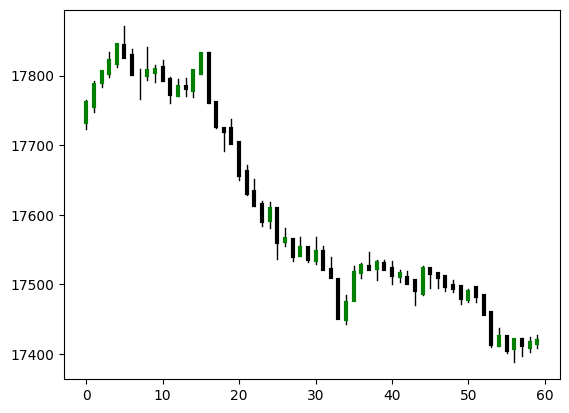

In [10]:
def plot_candles(candles):
    for index in range(len(candles)):
        candle = candles[index]
        c = "green" if candle.c > candle.o else "black"
        plt.plot([index, index], [candle.l, candle.h], linewidth=1, color = "black")
        plt.plot([index, index], [candle.c, candle.o], linewidth=3, color = c)
index+=1
#step(index)
plot_candles(m.m1_candles)
if(current_position.direction != 0):
    plt.axhline(current_position.entry, color = "g" if current_position.direction == 1 else "r")
    plt.axhline(current_position.sl, color = "orange")
    plt.axhline(current_position.tp, color = "orange")
if(current_order != None):
    plt.axhline(current_order.entry, color = "g" if current_order.direction == 1 else "r")
    plt.axhline(current_order.sl, color = "orange")
    plt.axhline(current_order.tp, color = "orange")
print(current_position.direction, equity_L[-1])

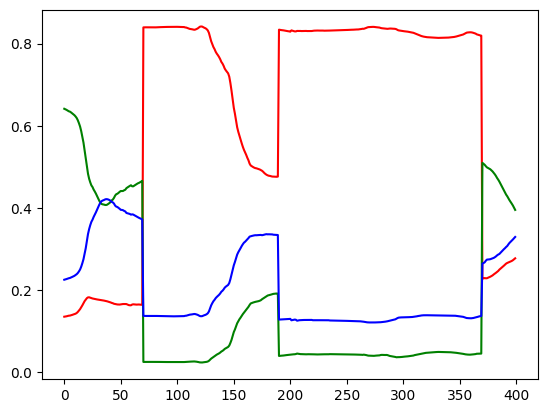

In [11]:
#plt.plot(outputs)
plt.plot([x[0] for x in outputs[-400:]], color="r")
plt.plot([x[1] for x in outputs[-400:]], color="g")
plt.plot([x[2] for x in outputs[-400:]], color="b")

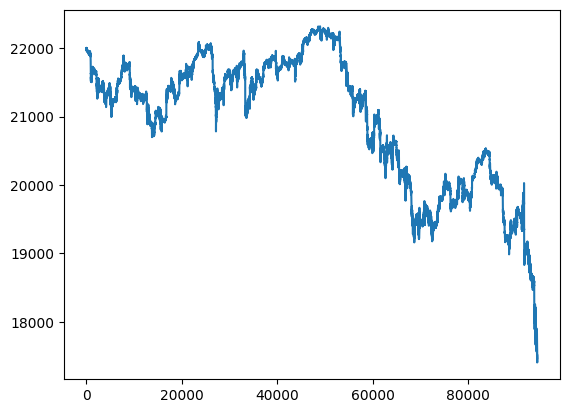

In [12]:
plt.plot([x.c for x in all_candles])

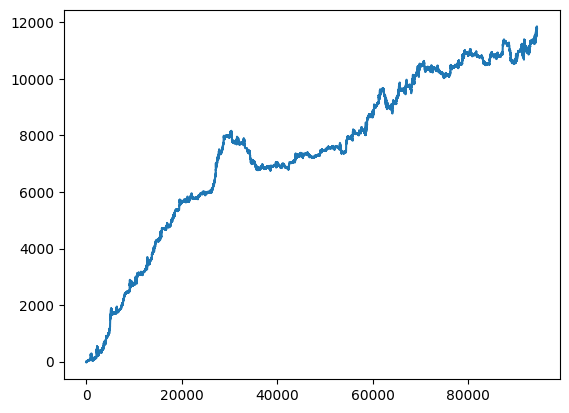

In [13]:
plt.plot(equity_L)

In [14]:
#plt.plot([x[1]-x[0] for x in outputs], color="b")